# Interface-based State Transition Analysis and Rate calculation (iSTAR) Workflow

This notebook implements the iSTAR method for calculating crossing probabilities (Pcross) from transition interface sampling (TIS) simulations using infretis weights. The iSTAR approach builds a Markov state model at the interfaces to efficiently calculate transition probabilities.

## Key Features:
- **Weight Calculation**: Uses infretis weights for proper statistical weighting of paths
- **Transition Matrix Construction**: Builds transition matrices from interface-to-interface transition probabilities  
- **Global Pcross Calculation**: Computes the global crossing probability using the iSTAR Markov model
- **WHAM Integration**: Incorporates WHAM-based methods for improved statistical accuracy

## Workflow Overview:
1. Load and process infretis simulation data
2. Calculate path weights using infretis methodology
3. Compute transition probabilities between interfaces
4. Construct the iSTAR transition matrix
5. Calculate global crossing probability from the Markov model
6. Compare with traditional WHAM methods

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pathlib
from typing import Dict, List, Tuple, Optional
import warnings

# Inftools imports
import sys
sys.path.append('/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/inftools')

from inftools.tistools.path_weights import get_path_weights
from inftools.analysis.Wham_Pcross import run_analysis
from inftools.misc.tomlreader import infretis_data_reader

print("Libraries imported successfully!")
print("Available functions:")
print("- get_path_weights: Calculate unbiased weights for paths")
print("- run_analysis: WHAM-based crossing probability analysis")
print("- read_toml: Read TOML configuration files")

Libraries imported successfully!
Available functions:
- get_path_weights: Calculate unbiased weights for paths
- run_analysis: WHAM-based crossing probability analysis
- read_toml: Read TOML configuration files


In [11]:
def calculate_infretis_weights(data_file: str, toml_file: str, nskip: int = 0) -> Dict:
    """
    Calculate infretis weights for paths, based on the path_weights.py methodology.
    Updated to handle ptype information and derive direction from aXMYb format.
    
    Parameters:
    -----------
    data_file : str
        Path to infretis_data.txt file
    toml_file : str  
        Path to infretis.toml configuration file
    nskip : int
        Number of initial entries to skip
        
    Returns:
    --------
    Dict containing path data and weights
    """
    import tomli
    import re
    import random
    
    def parse_ptype_direction(ptype):
        """
        Parse ptype to extract direction based on interface indices.
        Uses the exact logic from conv_inf_py.py
        """
        # Handle simple ptype formats (ensemble 0)
        if ptype in ['RMR', 'RML', 'LMR', 'LML']:
            return 1
        
        # Handle complex ptype formats with interface indices
        # Pattern to match: digits + letters + digits
        match = re.match(r'^(\d+)([LR]M[LR])(\d+)$', ptype)
        if match:
            try:
                a = int(match.group(1))  # First interface index
                b = int(match.group(3))  # Last interface index
                
                if a < b:
                    return 1
                elif a > b:
                    return -1
                else:  # a == b
                    return random.choice([1, -1])
            except ValueError:
                # If parsing fails, default to 1
                return 1
        
        # Default case
        return 1

    def extract_ptype_middle(ptype):
        """
        Extract the middle part (XMX) from ptype.
        Uses the exact logic from conv_inf_py.py
        """
        # Handle simple ptype formats (ensemble 0)
        if ptype in ['RMR', 'RML', 'LMR', 'LML']:
            return ptype
        
        # Handle complex ptype formats with interface indices
        match = re.match(r'^(\d+)([LR]M[LR])(\d+)$', ptype)
        if match:
            return match.group(2)  # Return the middle part (XMX)
        
        # Default case - return as is
        return ptype
    
    # Load configuration
    with open(toml_file, "rb") as f:
        toml_config = tomli.load(f)
    interfaces = toml_config["simulation"]["interfaces"]
    
    # Load data
    data = np.loadtxt(data_file, dtype=str, usecols=np.arange(16))
    data = data[nskip:]  # Skip initial entries
    
    # Check if we have ptype information (look for correct patterns)
    has_ptype = False
    ptype_col = None
    
    # Look for ptype patterns in the data - use correct patterns
    for col in range(data.shape[1]):
        sample_values = data[:10, col]  # Check first 10 rows
        for val in sample_values:
            if isinstance(val, str) and (re.match(r'\d+[LR]M[LR]\d+', val) or val in ['RMR', 'RML', 'LMR', 'LML']):
                has_ptype = True
                ptype_col = col
                break
        if has_ptype:
            break
    
    if has_ptype:
        print(f"Found ptype information in column {ptype_col}")
        # Extract direction information from ptype
        directions = []
        start_interfaces = []
        end_interfaces = []
        
        for i, row in enumerate(data):
            ptype = row[ptype_col]
            if isinstance(ptype, str):
                # Parse using the correct logic from conv_inf_py.py
                direction = parse_ptype_direction(ptype)
                directions.append(direction)
                
                # Extract start and end interface indices
                if ptype in ['RMR', 'RML', 'LMR', 'LML']:
                    # Simple format - ensemble 0
                    start_interfaces.append(0)
                    end_interfaces.append(0)
                else:
                    # Complex format with interface indices
                    match = re.match(r'^(\d+)([LR]M[LR])(\d+)$', ptype)
                    if match:
                        a = int(match.group(1))  # start interface index
                        b = int(match.group(3))  # end interface index
                        start_interfaces.append(a)
                        end_interfaces.append(b)
                    else:
                        start_interfaces.append(0)
                        end_interfaces.append(0)
            else:
                directions.append(0)  # Default for non-ptype entries
                start_interfaces.append(0)
                end_interfaces.append(0)
    else:
        print("No ptype information found, using standard format")
        directions = None
        start_interfaces = None
        end_interfaces = None
    
    # Identify non-zero paths (those with "----" in the zero-ensemble column)
    # Adjust column index based on whether ptype is present
    zero_col = 4 if not has_ptype else 5  # Assumes ptype is typically after maxop
    if zero_col < data.shape[1]:
        non_zero_paths = data[:, zero_col] == "----"
    else:
        # Fallback: look for "----" in any column after maxop
        non_zero_paths = data[:, 3] == "----"
    
    # Replace "----" with "0.0" for numerical processing
    data[data == "----"] = "0.0"
    
    # Extract path information
    D = {}
    D["pnr"] = data[non_zero_paths, 0:1].astype(int)  # Path numbers
    D["len"] = data[non_zero_paths, 1:2].astype(int)  # Path lengths
    D["maxop"] = data[non_zero_paths, 2:3].astype(float)  # Maximum order parameter
    
    # Add ptype-derived information if available
    if has_ptype:
        D["ptype"] = data[non_zero_paths, ptype_col]  # Path types
        D["direction"] = np.array([directions[i] for i in range(len(directions)) if non_zero_paths[i]])
        D["start_intf"] = np.array([start_interfaces[i] for i in range(len(start_interfaces)) if non_zero_paths[i]])
        D["end_intf"] = np.array([end_interfaces[i] for i in range(len(end_interfaces)) if non_zero_paths[i]])
    
    # Determine data columns for path_f and path_w
    data_start_col = ptype_col + 1 if has_ptype else 4
    D["path_f"] = data[non_zero_paths, data_start_col : data_start_col + len(interfaces)].astype(float)  # Path occurrences
    D["path_w"] = data[non_zero_paths, data_start_col + len(interfaces) : data_start_col + 2 * len(interfaces)].astype(float)  # Path weights
    
    # Calculate weights w = path_f / path_w
    w = D["path_f"] / D["path_w"]
    w[np.isnan(w)] = 0
    
    # Normalize weights to match total number of samples
    w = w / np.sum(w, axis=0) * np.sum(D["path_f"], axis=0)
    w[np.isnan(w)] = 0.0
    wsum = np.sum(w, axis=0)
    
    # # Calculate local crossing probabilities (ploc) using WHAM
    # ploc_wham = np.zeros(len(interfaces))
    # ploc_wham[0] = 1.0
    
    # for i, intf_p1 in enumerate(interfaces[1:]):
    #     h1 = D["maxop"] >= intf_p1
    #     nj = wsum[:i + 1]  # Number of paths crossing lambda_i for each ensemble up to i
    #     njl = np.sum(h1 * w[:, : i + 1], axis=0)  # Number of paths crossing lambda_i+1
    #     ploc_wham[i + 1] = np.sum(njl) / np.sum(nj / ploc_wham[: i + 1])
    
    # # Calculate unbiased path weights
    # A = np.zeros_like(D["maxop"])
    # Q = 1 / np.cumsum(wsum / ploc_wham[:-1])
    
    # for j, pathnr in enumerate(D["pnr"][:, 0]):
    #     # Find the highest interface crossed by this path
    #     K = min(
    #         np.where(D["maxop"][j] > interfaces)[0][-1] if np.any(D["maxop"][j] > interfaces) else 0, 
    #         len(interfaces) - 2
    #     )
    #     A[j] = Q[K] * np.sum(w[j])
    
    # Store results
    results = {
        'interfaces': interfaces,
        'path_data': D,
        'weights_matrix': w,
        # 'unbiased_weights': A,
        # 'ploc_wham': ploc_wham,
        # 'Q_factors': Q,
        'has_ptype': has_ptype
    }
    
    print(f"Processed {len(D['pnr'])} non-zero paths")
    print(f"Interfaces: {interfaces}")
    # print(f"Local crossing probabilities (WHAM): {ploc_wham}")
    
    if has_ptype:
        print(f"Path type information detected:")
        print(f"  Forward paths (dir=1): {np.sum(D['direction'] == 1)}")
        print(f"  Backward paths (dir=-1): {np.sum(D['direction'] == -1)}")
        print(f"  Other paths (dir=0): {np.sum(D['direction'] == 0)}")
    
    return results

print("Function calculate_infretis_weights updated with correct ptype handling from conv_inf_py.py!")

Function calculate_infretis_weights updated with correct ptype handling from conv_inf_py.py!


In [ ]:

def compute_weight_matrices_weights(weight_results: Dict, n_int: Optional[int] = None, tr: bool = True) -> Dict:
    """
    Compute 3D weight matrices from path data following original istar_analysis logic.
    
    This function constructs weight matrices [i,j,k] where:
    - i: ensemble index (path ensemble)
    - j: starting interface index
    - k: ending interface index
    
    Implements the original istar_analysis.py logic for:
    - tr (time reversal): boolean for applying time-reversal symmetry
    - Edge case handling for specific interface transitions
    - Proper direction mask logic and boundary conditions
    
    Parameters:
    -----------
    weight_results : Dict
        Results from calculate_infretis_weights function containing:
        - path_data (D): Dictionary with path information including path_f and path_w
        - interfaces: List of interface positions
        - has_ptype: Boolean indicating if ptype information is available
    tr : bool, optional
        If True, applies time-reversal symmetry by symmetrizing weight matrices.
        Default is False.
        
    Returns:
    --------
    Dict containing:
        - weight_matrix_3d: 3D array [i,j,k] with weights for ensemble i, from interface j to k
        - count_matrix_3d: 3D array [i,j,k] with path counts for ensemble i, from interface j to k
        - weight_matrix_2d: 2D array [j,k] with total weights (summed over ensembles)
        - count_matrix_2d: 2D array [j,k] with total count (summed over ensembles)
        - ensemble_totals: 1D array with total weights per ensemble
        - transition_summary: Dictionary with detailed transition statistics
        - tr_applied: Boolean indicating if time-reversal symmetry was applied
    """
    
    # Extract data from weight_results
    D = weight_results['path_data']
    if n_int is None:
        interfaces = weight_results['interfaces']
    else:
        interfaces = weight_results['interfaces'][:n_int]
    has_ptype = weight_results.get('has_ptype', False)
    
    n_interfaces = len(interfaces)
    n_ensembles = len(interfaces)  # Number of ensembles equals number of interfaces
    n_paths = len(D['pnr'])
    
    print(f"Computing weight matrices for {n_paths} paths")
    print(f"Structure: Dictionary of 2D matrices [ensemble_idx][start_interface, end_interface]")
    print(f"Dimensions: {n_ensembles} ensembles x {n_interfaces} interfaces x {n_interfaces} interfaces")
    print(f"Following original istar_analysis.py logic with tr={tr}")
    
    # Initialize dictionaries of 2D matrices {ensemble_i: [start_interface_j, end_interface_k]}
    weight_matrix_3d = {i: np.zeros((n_interfaces, n_interfaces)) for i in range(n_ensembles)}
    weight_matrix_3d_norm = {i: np.zeros((n_interfaces, n_interfaces)) for i in range(n_ensembles)}
    count_matrix_3d = {i: np.zeros((n_interfaces, n_interfaces)) for i in range(n_ensembles)}
    
    # Arrays to track totals
    ensemble_totals = np.zeros(n_ensembles)
    
    if has_ptype and 'start_intf' in D and 'end_intf' in D and 'direction' in D:
        print("Using ptype information with direction for istar_analysis-style computation")
        
        # Process each path
        for path_idx in range(n_paths):
            ptype = D['ptype'][path_idx]
            start_intf = int(D['start_intf'][path_idx])
            end_intf = int(D['end_intf'][path_idx])
            direction = int(D['direction'][path_idx])  # 1 for forward, -1 for backward, 0 for other
            
            # Validate interface indices
            if (((start_intf < 0 or start_intf >= n_interfaces) and
                (end_intf < 0 or end_intf >= n_interfaces)) or
                (start_intf >= n_interfaces-1 and end_intf >= n_interfaces-1 and n_int is not None)):
                continue

            start_intf = min(start_intf, n_interfaces - 1)  # Ensure within bounds
            end_intf = min(end_intf, n_interfaces - 1)  # Ensure within bounds
                
            # Process each ensemble for this path (following original istar_analysis logic)
            # Calculate weight as path_f / path_w
            path_f_k = D['path_f'][path_idx, :]
            path_w_k = np.array([min(D['path_w'][path_idx, i], 1.) for i in range(len(D['path_w'][path_idx, :]))])
            # weight_k = np.nan_to_num(path_f_k / path_w_k) if np.sum(path_w_k) != 0 else 0
            weight_k = path_f_k if np.sum(path_w_k) != 0 else 0
            # weight_k = np.nan_to_num(weight_k / np.sum(weight_k) * np.sum(path_f_k)) if (np.sum(path_w_k) != 0 or np.sum(path_f_k) != 0) else 0

            for i in range(1,n_ensembles):
                if np.sum(path_w_k) != 0 and np.sum(path_f_k) != 0:  # Only process non-zero entries
                # if weight_results['weights_matrix'][path_idx, i] != 0:
                    # weight = weight_results['weights_matrix'][path_idx, i]
                    weight = weight_k[i]
                    # assert(weight == weight_results['weights_matrix'][path_idx, i]), f"Weight mismatch for path {path_idx}, ensemble {i}: {weight} != {weight_results['weights_matrix'][path_idx, i]}"
                    # if not tr and ((i == 2 and "LML" in ptype) or (i == len(interfaces) - 1 and "RMR" in ptype)):
                    #     weight /= 2
                    #     if (i == 2 and "LML" in ptype):
                    #         weight /= 2  # Additional halving for LML in ensemble 2
                    # Apply original istar_analysis logic for j→k transitions
                    j, k = start_intf, end_intf
                    
                    # Determine if this path should be counted in ensemble i
                    should_count = False
                    
                    if j == k:
                        # Self-transitions: Special case for i==1 (ensemble 1) and j==0
                        if j == 0:
                            # Original logic: count LMR paths in ensemble 1 for 0→0 transitions
                            # if 'LMR' in D['ptype'][path_idx] or ('LML' in D['ptype'][path_idx] and D['maxop'][path_idx] >= interfaces[1]):
                            #     k = 1  # Adjust to next interface for ensemble 1
                            should_count = True
                        elif j == len(interfaces) - 1:
                            k = len(interfaces) - 2  # Last interface self-transition
                            should_count = True  # Original logic: count RMR paths in last ensemble
                        else:
                            print(j,k, ptype)
                            should_count = False
                            
                    elif j < k:
                        # Forward transitions (j → k where j < k)
                        
                        # Edge case 1: j==0 and k==1 (first interface to second)
                        if j == 0 and k == 1:
                            # print("shouldnt happen first")
                            if i != 2:
                                # Use direction==1 for forward paths
                                should_count = (direction == 1)
                                assert should_count
                            elif i == 2:
                                # Special case: ensemble 2 uses different logic
                                # In original: dir_mask = masks[i]["LML"]
                                should_count = True  # Simplified - would need LML mask
                                
                        # Edge case 2: Last interface transition
                        elif j == len(interfaces)-2 and k == len(interfaces)-1:
                            # print("shouldnt happen last")
                            # Original: dir_mask = masks[i]["RMR"]
                            should_count = True  # Simplified - would need RMR mask

                        elif i-1 in [j, k] and 1 < i < len(interfaces):
                            # print(f"path_w: {D['path_w'][path_idx, i]}, path_f: {D['path_f'][path_idx, i]}, weight: {weight}, j: {j}, k: {k}, i: {i}, ptype: {ptype}")
                            weight *= 2
                            should_count = True
                        else:
                            # Standard forward transitions
                            should_count = (direction == 1)
                            assert should_count
                            
                    else:
                        # Backward transitions (j → k where j > k)
                        
                        # Edge case 1: j==1 and k==0 (second interface to first)
                        if j == 1 and k == 0:
                            # print("shouldnt happen first backward")
                            if i != 2:
                                # Use direction==-1 for backward paths
                                should_count = (direction == -1)
                                assert should_count
                            elif i == 2:
                                # Special case: ensemble 2 uses different logic
                                should_count = True  # Simplified - would need LML mask
                                
                        # Edge case 2: Last interface backward transition
                        elif j == len(interfaces)-1 and k == len(interfaces)-2:
                            # print("shouldnt happen last backward")
                            # Original: dir_mask = masks[i]["RMR"]
                            should_count = True  # Simplified - would need RMR mask
                            
                        elif i-1 in [j, k] and 1 < i < len(interfaces):
                            # print(f"path_w: {D['path_w'][path_idx, i]}, path_f: {D['path_f'][path_idx, i]}, weight: {weight}, j: {j}, k: {k}, i: {i}, ptype: {ptype}")
                            weight *= 2
                            should_count = True
                        else:
                            # Standard backward transitions
                            should_count = (direction == -1)
                            assert should_count
                    
                    # Count the transition if criteria are met
                    if should_count:
                        
                        weight_matrix_3d[i][j, k] += weight
                        count_matrix_3d[i][j, k] += 1
                        ensemble_totals[i] += weight
    
    else:
        print("No ptype information with direction available")
        raise ValueError("Path data must contain 'start_intf', 'end_intf', and 'direction' for istar_analysis-style computation.")
    
    # Apply time-reversal symmetry if requested (following original istar_analysis logic)
    weight_matrix_3d_notr = {i: weight_matrix_3d[i].copy() for i in range(n_ensembles)}
    count_matrix_3d_notr = {i: count_matrix_3d[i].copy() for i in range(n_ensembles)}
    weight_matrix_2d_notr = np.zeros((n_interfaces, n_interfaces))
    count_matrix_2d_notr = np.zeros((n_interfaces, n_interfaces))
    if tr:
        print("Applying time-reversal symmetry (tr=True)")
        
        for i in range(n_ensembles):
            # Original edge case logic for time reversal
            # if i == 2 and weight_matrix_3d[i][1, 0] == 0:
            #     # In [1*] all LML paths are classified as 1 → 0 (for now).
            #     # Time reversal needs to be adjusted to compensate for this
            #     weight_matrix_3d[i][0, 1] *= 2
            #     print(f"  Applied tr edge case for ensemble 2: doubled weight_matrix_3d[{i}, 0, 1]")
                
            # elif i == len(interfaces)-1 and weight_matrix_3d[i][-2, -1] == 0:
            #     weight_matrix_3d[i][-1, -2] *= 2
            #     print(f"  Applied tr edge case for last ensemble: doubled weight_matrix_3d[{i}, -1, -2]")
            
            # Properly symmetrize the matrix: X[i] = (X[i] + X[i].T) / 2.0
            weight_matrix_3d[i] = (weight_matrix_3d[i] + weight_matrix_3d[i].T) / 2.0
            count_matrix_3d[i] = (count_matrix_3d[i] + count_matrix_3d[i].T) / 2.0
    
    # Calculate 2D matrices by summing over ensembles
    weight_matrix_2d = np.zeros((n_interfaces, n_interfaces))
    count_matrix_2d = np.zeros((n_interfaces, n_interfaces))

    for i in range(n_ensembles):
        weight_matrix_2d += weight_matrix_3d[i]
        count_matrix_2d += count_matrix_3d[i]
        weight_matrix_2d_notr += weight_matrix_3d_notr[i]
        count_matrix_2d_notr += count_matrix_3d_notr[i]
    
    # Create transition summary
    total_weight = sum(np.sum(weight_matrix_3d[i]) for i in range(n_ensembles))
    total_transitions = sum(np.sum(count_matrix_3d[i]) for i in range(n_ensembles))
    
    # Analyze transition types across all ensembles
    forward_transitions = 0
    backward_transitions = 0
    self_transitions = 0
    forward_weight = 0
    backward_weight = 0
    self_weight = 0 
    
    for i in range(n_ensembles):
        for j in range(n_interfaces):
            for k in range(n_interfaces):
                weight_ijk = weight_matrix_3d[i][j, k]
                count_ijk = count_matrix_3d[i][j, k]
                
                if count_ijk > 0:
                    if j < k:  # Forward transition
                        forward_transitions += count_ijk
                        forward_weight += weight_ijk
                    elif j > k:  # Backward transition
                        backward_transitions += count_ijk
                        backward_weight += weight_ijk
                    else:  # Self transition
                        self_transitions += count_ijk
                        self_weight += weight_ijk
    
    transition_summary = {
        'total_weight': total_weight,
        'total_transitions': total_transitions,
        'forward_transitions': forward_transitions,
        'backward_transitions': backward_transitions,
        'self_transitions': self_transitions,
        'forward_weight': forward_weight,
        'backward_weight': backward_weight,
        'self_weight': self_weight,
        'forward_weight_fraction': forward_weight / total_weight if total_weight > 0 else 0,
        'backward_weight_fraction': backward_weight / total_weight if total_weight > 0 else 0,
        'self_weight_fraction': self_weight / total_weight if total_weight > 0 else 0
    }
    
    # Print detailed results following original istar_analysis style
    print(f"\n=== 3D WEIGHT MATRICES RESULTS (istar_analysis style) ===")
    print(f"3D Matrix dimensions: {n_ensembles} x {n_interfaces} x {n_interfaces}")
    print(f"Total weight processed: {total_weight:.6f}")
    print(f"Total transitions: {total_transitions}")
    print(f"Non-zero 3D matrix elements: {sum(np.count_nonzero(weight_matrix_3d[i]) for i in range(n_ensembles))}")
    print(f"Time-reversal symmetry applied: {tr}")
    
    # Print ensemble weights (like original "Sum weights ensemble i")
    print(f"\nEnsemble weight totals:")
    for i in range(n_ensembles):
        ensemble_sum = np.sum(weight_matrix_3d[i])
        print(f"  Sum weights ensemble {i}: {ensemble_sum:.4f}")
    
    print(f"\n2D Weight Matrix [start_interface, end_interface] (summed over ensembles):")
    print("Rows = start interface, Columns = end interface")
    for j in range(n_interfaces):
        row_str = f"Interface {j}: "
        for k in range(n_interfaces):
            row_str += f"{weight_matrix_2d[j, k]:8.4f} "
        print(row_str)
    
    print(f"\nTransition Analysis:")
    print(f"Forward transitions (j<k):  {forward_transitions:4f} paths, {forward_weight:8.4f} weight ({transition_summary['forward_weight_fraction']:.1%})")
    print(f"Backward transitions (j>k): {backward_transitions:4f} paths, {backward_weight:8.4f} weight ({transition_summary['backward_weight_fraction']:.1%})")
    print(f"Self transitions (j=k):     {self_transitions:4f} paths, {self_weight:8.4f} weight ({transition_summary['self_weight_fraction']:.1%})")

    # Show some 3D matrix details for non-zero entries
    print(f"\nNon-zero 3D matrix entries (first 10):")
    count = 0
    for i in range(n_ensembles):
        for j in range(n_interfaces):
            for k in range(n_interfaces):
                if weight_matrix_3d[i][j, k] > 0 and count < 10:
                    print(f"  weights[{i},{j},{k}] = {weight_matrix_3d[i][j, k]:.6f} (count: {count_matrix_3d[i][j, k]:.1f})")
                    count += 1
                if count >= 10:
                    break
            if count >= 10:
                break
        if count >= 10:
            break
    
    # Store and return results
    results = {
        'weight_matrix_3d': weight_matrix_3d,
        'count_matrix_3d': count_matrix_3d,
        'weight_matrix_3d_notr': weight_matrix_3d_notr,
        'count_matrix_3d_notr': count_matrix_3d_notr,
        'weight_matrix_2d': weight_matrix_2d,
        'count_matrix_2d': count_matrix_2d,
        'weight_matrix_2d_notr': weight_matrix_2d_notr,
        'count_matrix_2d_notr': count_matrix_2d_notr,
        'ensemble_totals': ensemble_totals,
        'transition_summary': transition_summary,
        'tr_applied': tr,
        'interfaces': interfaces,
        'n_interfaces': n_interfaces,
        'n_ensembles': n_ensembles,
        'total_paths_processed': n_paths
    }
    
    return results

print("Function compute_weight_matrices_weights updated with original istar_analysis.py logic!")

Function compute_weight_matrices_weights updated with original istar_analysis.py logic!


In [51]:
def display_data_infretis(weight_matrices_result: Dict, threshold_w: float = 0.03, threshold_tr: float = 0.05) -> None:
    """
    Display detailed analysis of infretis weight matrices in a format similar to display_data.
    
    This function provides comprehensive inspection of transition data from infretis weights,
    including raw counts, weighted transitions, and time-reversal statistics. It's adapted
    from the original display_data function to work with infretis data structures.
    
    Parameters:
    -----------
    weight_matrices_result : Dict
        Results from compute_weight_matrices_weights function containing:
        - weight_matrix_3d: Dictionary of 2D weight matrices {ensemble_i: [j,k]}
        - count_matrix_3d: Dictionary of 2D count matrices {ensemble_i: [j,k]}
        - weight_matrix_2d: 2D total weight matrix [j,k]
        - ensemble_totals: Array of total weights per ensemble
        - transition_summary: Dictionary with transition statistics
        - interfaces: List of interface positions
        - tr_applied: Boolean indicating if time-reversal was applied
    threshold_w : float, optional
        Threshold for detecting significant differences between weighted and raw data.
        Default is 0.03 (3%).
    threshold_tr : float, optional
        Threshold for detecting time-reversal symmetry violations. Default is 0.05 (5%).
        
    Returns:
    --------
    None
        This function only displays information and does not return values.
        
    Notes:
    ------
    This function provides similar diagnostics to the original display_data but adapted
    for the infretis workflow data structures. It helps identify:
    - Statistical anomalies in path weighting
    - Time-reversal symmetry violations
    - Insufficient sampling at specific interfaces
    - Unusual transition patterns
    """
    
    # Extract data from results
    weight_matrix_3d = weight_matrices_result['weight_matrix_3d']
    count_matrix_3d = weight_matrices_result['count_matrix_3d']
    weight_matrix_2d = weight_matrices_result['weight_matrix_2d']
    count_matrix_3d_notr = weight_matrices_result['count_matrix_3d_notr']
    weight_matrix_3d_notr = weight_matrices_result['weight_matrix_3d_notr']
    ensemble_totals = weight_matrices_result['ensemble_totals']
    interfaces = weight_matrices_result['interfaces']
    n_interfaces = len(interfaces)
    n_ensembles = len(weight_matrix_3d)
    tr_applied = weight_matrices_result.get('tr_applied', False)
    
    print("="*60)
    print("INFRETIS WEIGHT MATRICES ANALYSIS")
    print("="*60)
    print(f"Structure: {n_ensembles} ensembles × {n_interfaces} interfaces × {n_interfaces} interfaces")
    print(f"Time-reversal symmetry applied: {tr_applied}")
    print(f"Warning thresholds: weight differences ≥ {threshold_w:.1%}, TR violations ≥ {threshold_tr:.1%}")
    
    # Process each ensemble
    for i in range(n_ensembles):
        print(f"\n{'-'*10}")
        print(f"ENSEMBLE [{i-1 if i>0 else 0}{'*' if i>0 else '-'}] | ID {i}")
        print(f"{'-'*10}")
        
        # Get matrices for this ensemble
        X_i = weight_matrix_3d_notr[i]  # Weighted matrix
        C_i = count_matrix_3d_notr[i]   # Count matrix (raw paths)
        
        # Calculate fractions for anomaly detection
        total_X = np.sum(X_i)
        total_C = np.sum(C_i)
        
        if total_X > 0 and total_C > 0:
            frac_w = X_i / total_X
            frac_c = C_i / total_C
            diff_frac = np.abs(frac_w - frac_c)
            
            # Find significant differences between weighted and raw data
            idx_weird_w = np.argwhere(diff_frac >= threshold_w)
        else:
            idx_weird_w = []
            diff_frac = np.zeros_like(X_i)
        
        # Calculate time-reversal symmetry violations
        X_sym = (X_i + X_i.T) / 2.0
        tr_diff = np.zeros_like(X_i)
        
        # Only calculate TR differences for non-zero entries
        mask = (X_i + X_i.T) > 0
        tr_diff[mask] = np.abs(X_i[mask] - X_i.T[mask]) / X_sym[mask]
        
        idx_tr = np.argwhere(tr_diff >= threshold_tr)
        # Remove duplicates (only keep lower triangle)
        idx_tr = [(min(a, b), max(a, b)) for a, b in idx_tr]
        idx_tr = list(set(idx_tr))
        
        # 1. Raw unweighted path counts
        print(f"\n1a. Raw data: unweighted count matrix C[{i}] (notr)")
        print(np.array2string(C_i, precision=1, suppress_small=True))
        
        # 2. Weighted data
        print(f"\n1b. Weighted data: X[{i}] (notr)")
        print(np.array2string(X_i, precision=4, suppress_small=True))
        print(f"Total weight ensemble {i}: {np.sum(X_i):.4f}")
        
        # Warnings for significant differences between weighted and raw data
        if len(idx_weird_w) > 0:
            print(f"\n[WARNING] Significant differences between weighted and raw data (≥{threshold_w:.1%}):")
            for idx in idx_weird_w:
                j, k = idx[0], idx[1]
                print(f"  Path {j} → {k}: raw count={C_i[j, k]:.1f}, "
                      f"weighted={X_i[j, k]:.4f}, "
                      f"fraction diff={diff_frac[j, k]:.4f}")
        
        # 3. Time-reversal symmetry analysis (if applied)
        if tr_applied:
            print(f"\n2a. Time-reversal symmetrized count matrix C_tr[{i}]:")
            C_sym = (C_i + C_i.T) / 2.0
            print(np.array2string(C_sym, precision=1, suppress_small=True))
            
            print(f"\n2b. Time-reversal symmetrized weight matrix X_tr[{i}]:")
            print(np.array2string(X_sym, precision=4, suppress_small=True))
            
            # Warnings for time-reversal symmetry violations
            if len(idx_tr) > 0:
                print(f"\n[WARNING] Time-reversal symmetry violations (≥{threshold_tr:.1%}):")
                for idx in idx_tr:
                    j, k = idx[0], idx[1]
                    print(f"  Path {j} ↔ {k}: relative diff={tr_diff[j, k]:.4f}, "
                          f"forward weight={X_i[j, k]:.4f}, "
                          f"backward weight={X_i[k, j]:.4f}")
        else:
            print(f"\n2. Time-reversal symmetry not applied for this analysis")
        
        # Warning for insufficient sampling at interfaces
        total_weight = np.sum(X_i)
        if total_weight > 0:
            col_sums = np.sum(X_i, axis=0)
            row_sums = np.sum(X_i, axis=1)
            n_cols = X_i.shape[1]
            threshold_sampling = total_weight / (5 * n_cols)  # 20% of average
            
            low_cols = np.where(col_sums < threshold_sampling)[0]
            low_rows = np.where(row_sums < threshold_sampling)[0]
            
            if len(low_cols) > 0:
                print(f"\n[WARNING] Interfaces with insufficient sampling (incoming):")
                for col in low_cols:
                    print(f"  Interface {col}: incoming weight={col_sums[col]:.4f}, "
                          f"only {(col_sums[col]/total_weight)*100:.1f}% of total "
                          f"(threshold: {threshold_sampling:.4f})")
            
            if len(low_rows) > 0:
                print(f"\n[WARNING] Interfaces with insufficient sampling (outgoing):")
                for row in low_rows:
                    print(f"  Interface {row}: outgoing weight={row_sums[row]:.4f}, "
                          f"only {(row_sums[row]/total_weight)*100:.1f}% of total "
                          f"(threshold: {threshold_sampling:.4f})")
    
    # Combined statistics across all ensembles
    print(f"\n{'='*40}")
    print("ALL ENSEMBLES COMBINED")
    print(f"{'-'*20}")
    
    # Combined weight matrix (already calculated)
    print(f"\n3a. Combined weight matrix (sum over all ensembles, notr):")
    print("Rows = start interface, Columns = end interface")
    print(np.array2string(weight_matrix_2d, precision=4, suppress_small=True))
    
    # Combined count matrix
    combined_count_matrix = np.zeros_like(weight_matrix_2d)
    for i in range(n_ensembles):
        combined_count_matrix += count_matrix_3d[i]
    
    print(f"\n3b. Combined count matrix (sum over all ensembles, notr):")
    print("Rows = start interface, Columns = end interface")
    print(np.array2string(combined_count_matrix, precision=1, suppress_small=True))
    
    # Combined with time-reversal symmetry
    if tr_applied:
        weight_matrix_2d_tr = (weight_matrix_2d + weight_matrix_2d.T) / 2.0
        combined_count_matrix_tr = (combined_count_matrix + combined_count_matrix.T) / 2.0
        
        print(f"\n4a. Combined weight matrix with time-reversal symmetry:")
        print(np.array2string(weight_matrix_2d_tr, precision=4, suppress_small=True))
        
        print(f"\n4b. Combined count matrix with time-reversal symmetry:")
        print(np.array2string(combined_count_matrix_tr, precision=1, suppress_small=True))
    
    # Overall statistics
    transition_summary = weight_matrices_result.get('transition_summary', {})
    total_weight = transition_summary.get('total_weight', np.sum(weight_matrix_2d))
    
    print(f"\n=== OVERALL STATISTICS ===")
    print(f"Total weight across all ensembles: {total_weight:.4f}")
    print(f"Total transitions: {transition_summary.get('total_transitions', 0)}")
    print(f"Non-zero matrix elements: {np.count_nonzero(weight_matrix_2d)}/{n_interfaces*n_interfaces}")
    
    # Transition type breakdown
    if transition_summary:
        print(f"\nTransition breakdown:")
        print(f"• Forward (j<k):  {transition_summary.get('forward_weight', 0):.4f} "
              f"({transition_summary.get('forward_weight_fraction', 0):.1%})")
        print(f"• Backward (j>k): {transition_summary.get('backward_weight', 0):.4f} "
              f"({transition_summary.get('backward_weight_fraction', 0):.1%})")
        print(f"• Self (j=k):     {transition_summary.get('self_weight', 0):.4f} "
              f"({transition_summary.get('self_weight_fraction', 0):.1%})")
    
    # Interface activity analysis
    print(f"\nInterface activity analysis:")
    interface_activity = np.sum(weight_matrix_2d, axis=0) + np.sum(weight_matrix_2d, axis=1)
    for i, activity in enumerate(interface_activity):
        print(f"  Interface {i}: total activity = {activity:.4f} "
              f"({(activity/np.sum(interface_activity))*100:.1f}% of total)")
    
    print(f"\n{'='*60}")
    print("Analysis complete. Check warnings above for potential issues.")

print("Function display_data_infretis successfully defined!")

Function display_data_infretis successfully defined!


In [52]:
def construct_istar_transition_matrix(P: np.ndarray, N: int) -> np.ndarray:
    """
    Construct the iSTAR transition matrix M from interface-to-interface transition probabilities.
    
    This implements the iSTAR model structure where states are defined at each interface
    with special handling for boundary states.
    
    Parameters:
    -----------
    P : np.ndarray
        Array of probabilities for paths between interfaces. P[i,j] represents the 
        probability of a path transitioning from interface i to interface j.
    N : int
        Number of interfaces in the system.
    
    Returns:
    --------
    np.ndarray
        Transition matrix M for the iSTAR model with dimensions (2*N, 2*N).
    """
    NS = 2 * N  # Dimension of the Markov state model
    
    # Validate input dimensions
    if P.shape[0] != N or P.shape[1] != N:
        raise ValueError(f"P matrix dimensions {P.shape} don't match N={N}")
    
    # Construct transition matrix
    M = np.zeros((NS, NS))
    
    # States [0-] and [0*+-] - special boundary handling
    M[0, 2] = 1            # Transition from state 0 to state 2
    M[2, 0] = P[0, 0]      # Transition from state 2 to state 0
    M[2, N+1:] = P[0, 1:]  # Transitions from state 2 to states N+1 and beyond
    M[1, 0] = 1            # Transition from state 1 to state 0
    M[-1, 0] = 1           # Transition from last state to state 0
    
    # Transitions from intermediate states to boundary
    if N > 1:
        M[N+1:-1, 1] = P[1:-1, 0]  # Transitions to state 1
    
    # Set up transitions for other interfaces
    for i in range(1, N-1):
        # Forward transitions
        if i < N-1:
            M[N+i, N+i+1:] = P[i, i+1:]
        # Backward transitions
        if i > 0:
            M[N+i, N+1:N+i] = P[i, 1:i]
    
    # Handle the last interface (special case)
    if N > 1:
        M[N, -1] = P[N-1, N-1] if N-1 < P.shape[1] else 0  # Self-transition or to absorbing state
    
    # Ensure matrix is properly stochastic (rows sum to 1)
    for i in range(NS):
        row_sum = np.sum(M[i, :])
        if row_sum == 0:
            M[i, i] = 1  # Set diagonal entry to 1 for rows that sum to zero
        elif row_sum > 0 and not np.isclose(row_sum, 1.0):
            M[i, :] /= row_sum  # Normalize to ensure stochastic matrix
    
    print(f"Constructed iSTAR transition matrix with shape {M.shape}")
    print(f"Matrix properties:")
    print(f"- Row sums: {[np.sum(M[i, :]) for i in range(min(5, NS))]}")
    print(f"- Non-zero entries: {np.count_nonzero(M)}/{NS*NS}")
    
    return M

def global_pcross_istar(M: np.ndarray, doprint: bool = False) -> Tuple:
    """
    Calculate global crossing probabilities from a transition matrix using the iSTAR approach.
    
    This function computes the probability to arrive at state -1 before reaching state 0,
    given that we start at state 0 and leave it.
    
    Parameters:
    -----------
    M : np.ndarray
        Transition matrix representing the Markov state model
    doprint : bool
        If True, prints detailed calculation information
        
    Returns:
    --------
    tuple
        (z1, z2, y1, y2) - solution vectors from the iSTAR calculation
    """
    NS = len(M)
    if NS <= 2:
        print("Warning: Matrix too small for meaningful iSTAR analysis")
        return None, None, None, None
    
    # Extract submatrices from the transition matrix
    Mp = M[2:-1, 2:-1]  # Transition probabilities between intermediate states
    a = np.identity(NS-3) - Mp  # I - Mp, used for solving linear system
    
    # Extract other submatrices from the transition matrix
    D = M[2:-1, np.array([0, -1])]  # Transitions from intermediate states to boundary states
    E = M[np.array([0, -1]), 2:-1]  # Transitions from boundary states to intermediate states
    M11 = M[np.array([0, -1]), np.array([0, -1])]  # Transitions between boundary states
    
    # Compute Z vector - solve the linear system
    z1 = np.array([[0], [1]])  # Initial condition
    try:
        z2 = np.linalg.solve(a, np.dot(D, z1))  # Solve (I-Mp)z2 = D·z1
    except np.linalg.LinAlgError:
        print("Warning: Singular matrix encountered in iSTAR calculation")
        return None, None, None, None
    
    # Compute H vector - final probability distribution
    y1 = np.dot(M11, z1) + np.dot(E, z2)  # Transitions to boundary states
    y2 = np.dot(D, z1) + np.dot(Mp, z2)   # Transitions to intermediate states
    
    if doprint:
        print("iSTAR calculation details:")
        print(f"Intermediate states matrix Mp shape: {Mp.shape}")
        print(f"Boundary transition matrix D shape: {D.shape}")
        print(f"z1 (boundary conditions): {z1.flatten()}")
        print(f"z2 (intermediate solutions): {z2.flatten()}")
        print(f"y1 (boundary probabilities): {y1.flatten()}")
        print(f"Global crossing probability: {y1[1, 0] if y1.shape[0] > 1 else 'N/A'}")
    
    return z1, z2, y1, y2

print("iSTAR matrix construction functions defined successfully!")

iSTAR matrix construction functions defined successfully!


In [53]:
def calculate_binless_pcross(weight_results: Dict) -> Tuple[np.ndarray, np.ndarray]:
    """
    Calculate binless crossing probability from infretis weights.
    
    This is based on the method in path_weights.py and provides a direct
    calculation of the crossing probability curve.
    
    Parameters:
    -----------
    weight_results : Dict
        Results from calculate_infretis_weights function
        
    Returns:
    --------
    tuple
        (order_params, pcross_values) - arrays for plotting/analysis
    """
    D = weight_results['path_data']
    A = weight_results['unbiased_weights']
    interfaces = weight_results['interfaces']
    
    # Sort paths by maximum order parameter
    idx = np.argsort(D["maxop"].flatten())
    maxop_sorted = D["maxop"][idx].flatten()
    weight_sorted = A[idx].flatten()
    sumw = np.sum(weight_sorted)
    
    # Calculate crossing probability
    res_y = [1.0]
    res_x = [interfaces[0]]
    
    for i, moi in enumerate(maxop_sorted):
        # Skip duplicate order parameter values
        if res_x[-1] == moi:
            continue
        # Crossing probability = sum of weights of paths that cross this point / total weight
        res_y.append(np.sum(weight_sorted[i:]) / sumw)
        res_x.append(moi)
    
    res_x = np.array(res_x)
    res_y = np.array(res_y)
    
    print(f"Calculated binless crossing probability with {len(res_x)} points")
    print(f"Order parameter range: {res_x.min():.3f} to {res_x.max():.3f}")
    print(f"Crossing probability range: {res_y.min():.6f} to {res_y.max():.6f}")
    
    return res_x, res_y

def plot_pcross_comparison(results_dict: Dict, title: str = "Crossing Probability Comparison"):
    """
    Plot comparison of different crossing probability calculations.
    
    Parameters:
    -----------
    results_dict : Dict
        Dictionary containing different pcross calculations with keys:
        - 'binless': (x, y) tuple from binless calculation
        - 'istar': global crossing probability from iSTAR
        - 'interfaces': interface positions
    """
    plt.figure(figsize=(12, 8))
    
    # Plot binless crossing probability
    if 'binless' in results_dict:
        x_binless, y_binless = results_dict['binless']
        plt.semilogy(x_binless, y_binless, 'b-', linewidth=2, label='Binless (infretis weights)')
    
    # Plot interfaces
    if 'interfaces' in results_dict:
        interfaces = results_dict['interfaces']
        for i, intf in enumerate(interfaces):
            plt.axvline(intf, color='black', linestyle='--', alpha=0.7, linewidth=1)
            plt.text(intf, 0.5, f'λ_{i}', rotation=90, verticalalignment='center')
    
    # Add iSTAR global crossing probability if available
    if 'istar_global' in results_dict:
        istar_pcross = results_dict['istar_global']
        plt.axhline(istar_pcross, color='red', linestyle='-', linewidth=2, 
                   label=f'iSTAR Global P_cross = {istar_pcross:.6f}')
    
    plt.xlabel('Order Parameter (λ)')
    plt.ylabel('Crossing Probability P(λ)')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.ylim(1e-6, 1.1)
    plt.tight_layout()
    plt.show()

print("Binless crossing probability and plotting functions defined successfully!")

Binless crossing probability and plotting functions defined successfully!


## Data Loading and Configuration

In this section, we'll load the infretis simulation data and configure the analysis parameters. The example uses the test data from the double-well system.

In [54]:
def create_test_data_with_ptype(filename: str, n_paths: int = 50, n_interfaces: int = 4):
    """
    Create test infretis_data.txt with ptype information for demonstration.
    
    This generates synthetic data with the correct aXMXb ptype format where:
    - a = start interface index
    - b = end interface index  
    - X can be L or R (representing left/right movement)
    - direction = 1 if a < b, -1 if a > b, random if a == b
    
    Parameters:
    -----------
    filename : str
        Output filename for the test data
    n_paths : int
        Number of paths to generate
    n_interfaces : int
        Number of interfaces
    """
    import random
    
    interfaces = [-1.0, -0.5, 0.0, 0.5, 1.0][:n_interfaces+1]  # Example interface positions
    
    with open(filename, 'w') as f:
        # Write header
        f.write("# Test data with ptype information\n")
        f.write("# path_nr\tlength\tmaxop\tptype\t")
        f.write("\t".join([f"ens{i:03d}" for i in range(n_interfaces)]))
        f.write("\t")
        f.write("\t".join([f"wgt{i:03d}" for i in range(n_interfaces)]))
        f.write("\n")
        
        # Generate synthetic paths
        for path_nr in range(n_paths):
            # Random path properties
            length = random.randint(10, 100)
            
            # Random start and end interfaces
            start_intf = random.randint(0, n_interfaces-1)
            end_intf = random.randint(0, n_interfaces-1)
            
            # Create ptype in correct aXMXb format from conv_inf_py.py
            if start_intf == 0 and end_intf == 0:
                # Simple format for ensemble 0
                ptype = random.choice(['RMR', 'RML', 'LMR', 'LML'])
            else:
                # Complex format with interface indices
                # Choose random middle part
                middle_parts = ['LMR', 'RML', 'LML', 'RMR']
                middle = random.choice(middle_parts)
                ptype = f"{start_intf}{middle}{end_intf}"
            
            # Maximum order parameter should be consistent with the path
            if end_intf >= start_intf:  # Forward path
                maxop = random.uniform(interfaces[start_intf], interfaces[end_intf+1] if end_intf < len(interfaces)-1 else 1.5)
            else:  # Backward path
                maxop = random.uniform(interfaces[end_intf], interfaces[start_intf+1] if start_intf < len(interfaces)-1 else 1.5)
            
            # Generate ensemble data (path_f and path_w)
            path_f = []
            path_w = []
            
            for i in range(n_interfaces):
                if i == start_intf:
                    # Path contributes to starting ensemble
                    f_val = random.uniform(0.5, 2.0)
                    w_val = random.uniform(0.5, 2.0)
                    path_f.append(f_val)
                    path_w.append(w_val)
                else:
                    # No contribution to other ensembles
                    path_f.append("----")
                    path_w.append("----")
            
            # Write path data
            f.write(f"{path_nr}\t{length}\t{maxop:.5f}\t{ptype}\t")
            f.write("\t".join([str(x) for x in path_f]))
            f.write("\t")
            f.write("\t".join([str(x) for x in path_w]))
            f.write("\n")
    
    print(f"Created test data file: {filename}")
    print(f"Generated {n_paths} paths with {n_interfaces} interfaces")
    print(f"File includes ptype information in correct aXMXb format")

# Test if we want to demonstrate with synthetic data
def test_ptype_format():
    """Test the ptype format parsing with synthetic data"""
    test_file = "test_infretis_data_with_ptype.txt"
    create_test_data_with_ptype(test_file, n_paths=20, n_interfaces=3)
    
    # Show first few lines
    with open(test_file, 'r') as f:
        lines = f.readlines()
    
    print("\nFirst few lines of generated test data:")
    for i, line in enumerate(lines[:8]):
        print(f"{i+1}: {line.strip()}")
    
    return test_file

print("Test data generation functions updated with correct ptype format!")

Test data generation functions updated with correct ptype format!


In [56]:
# Configuration for the analysis
# DATA_DIR = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/inftools/test/test_staple"
# DATA_DIR = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_ase"
DATA_DIR = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br"
# DATA_DIR = "/mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br_0swnoinf"

TOML_FILE = f"{DATA_DIR}/infretis.toml"
DATA_FILE = f"{DATA_DIR}/infretis_data.txt"
# DATA_FILE = f"{DATA_DIR}/2308noinfswap_data.txt"

# Analysis parameters
NSKIP = 0  # Number of initial entries to skip
VERBOSE = True
USE_TEST_PTYPE_DATA = False  # Set to True to demonstrate ptype functionality

print("Configuration:")
print(f"Data directory: {DATA_DIR}")
print(f"TOML file: {TOML_FILE}")
print(f"Data file: {DATA_FILE}")

# Check if files exist
import os
if os.path.exists(TOML_FILE):
    print("✓ TOML file found")
else:
    print("✗ TOML file not found")
    
if os.path.exists(DATA_FILE):
    print("✓ Data file found")
    # Show basic info about the data file
    with open(DATA_FILE, 'r') as f:
        lines = f.readlines()
    print(f"  - Total lines: {len(lines)}")
    print(f"  - First few lines:")
    for i, line in enumerate(lines[:5]):
        print(f"    {i+1}: {line.strip()}")
else:
    print("✗ Data file not found")

# Option to demonstrate ptype functionality
if USE_TEST_PTYPE_DATA:
    print(f"\n{'='*50}")
    print("DEMONSTRATING PTYPE FUNCTIONALITY")
    print(f"{'='*50}")
    
    # Create test data with ptype information
    test_data_file = test_ptype_format()
    
    # Create a simple TOML config for the test
    test_toml_content = '''
    [simulation]
    interfaces = [-1.0, -0.5, 0.0, 0.5]
    '''
    
    test_toml_file = "test_infretis.toml"
    with open(test_toml_file, 'w') as f:
        f.write(test_toml_content)
    
    print(f"\\nSwitching to test data for ptype demonstration:")
    print(f"Test TOML file: {test_toml_file}")
    print(f"Test data file: {test_data_file}")
    
    # Override the configuration
    TOML_FILE = test_toml_file
    DATA_FILE = test_data_file
    
    print("\\n✓ Test configuration ready for ptype demonstration")
else:
    print(f"\\nUsing standard data format (no ptype information)")
    print(f"Set USE_TEST_PTYPE_DATA = True to demonstrate ptype functionality")

Configuration:
Data directory: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br
TOML file: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/infretis.toml
Data file: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/infretis_data.txt
✓ TOML file found
✓ Data file found
  - Total lines: 40200
  - First few lines:
    1: # ==========================================================================
    2: # 	xxx	len	max OP		000	001	002	003	004
    3: # ==========================================================================
    4: 3	 1170	 0.30010	-0.10011	0LMR4	----	----	----	----	----	----	----	----	----	----	('ld', nan, 0, 0)	2
    5: 0	 3021	-0.09986	-0.36087	RMR	1.0	----	----	----	----	1.0	----	----	----	----	('ld', nan, 0, 0)	-1
\nUsing standard data format (no ptype information)
Set USE_TEST_PTYPE_DATA = True to demonstrate ptype functionali

## Step 1: Calculate Infretis Weights

First, we calculate the unbiased weights for all paths using the infretis methodology. This is the key improvement over the old workflow - using proper infretis weights instead of simple path counts.

In [57]:
# Demonstrate format detection and ptype parsing
print("=== DATA FORMAT ANALYSIS ===")

# Load and analyze the data format
try:
    data_sample = np.loadtxt(DATA_FILE, dtype=str, max_rows=10, usecols=np.arange(16)) 
    print(f"Data shape: {data_sample.shape}")
    print(f"Number of columns: {data_sample.shape[1]}")
    
    # Check for ptype patterns - correct pattern from conv_inf_py.py
    import re
    ptype_found = False
    ptype_examples = []
    
    for col in range(data_sample.shape[1]):
        for row in range(data_sample.shape[0]):
            val = data_sample[row, col]
            # Look for patterns like "0LMR4", "10RML12", or simple "RMR", "LML" etc.
            if isinstance(val, str) and (re.match(r'\d+[LR]M[LR]\d+', val) or val in ['RMR', 'RML', 'LMR', 'LML']):
                ptype_found = True
                ptype_examples.append(val)
                print(f"Found ptype pattern '{val}' in column {col}, row {row}")
                
                # Parse and show direction using the correct logic from conv_inf_py.py
                if val in ['RMR', 'RML', 'LMR', 'LML']:
                    # Simple format (ensemble 0)
                    direction = 1
                    print(f"  -> Simple ptype format, Direction: {direction}")
                else:
                    # Complex format with interface indices
                    match = re.match(r'^(\d+)([LR]M[LR])(\d+)$', val)
                    if match:
                        a = int(match.group(1))  # First interface index
                        b = int(match.group(3))  # Last interface index
                        middle_part = match.group(2)  # XMX part
                        
                        if a < b:
                            direction = 1
                        elif a > b:
                            direction = -1
                        else:  # a == b
                            direction = 1  # or random choice as in conv file
                        
                        print(f"  -> Start interface: {a}, End interface: {b}, Middle: {middle_part}, Direction: {direction}")
    
    if not ptype_found:
        print("No ptype patterns (aXMXb format) detected in the data")
        print("This data uses the standard infretis format")
    else:
        print(f"\nPtype examples found: {list(set(ptype_examples))}")
    
    print(f"\nData preview (first 3 rows):")
    for i in range(min(3, data_sample.shape[0])):
        print(f"Row {i}: {data_sample[i]}")

except Exception as e:
    print(f"Error analyzing data format: {e}")

print(f"\n{'='*50}")

=== DATA FORMAT ANALYSIS ===
Data shape: (10, 16)
Number of columns: 16
Found ptype pattern '0LMR4' in column 4, row 0
  -> Start interface: 0, End interface: 4, Middle: LMR, Direction: 1
Found ptype pattern 'RMR' in column 4, row 1
  -> Simple ptype format, Direction: 1
Found ptype pattern '0LMR1' in column 4, row 2
  -> Start interface: 0, End interface: 1, Middle: LMR, Direction: 1
Found ptype pattern '0LMR4' in column 4, row 3
  -> Start interface: 0, End interface: 4, Middle: LMR, Direction: 1
Found ptype pattern '2RMR4' in column 4, row 4
  -> Start interface: 2, End interface: 4, Middle: RMR, Direction: 1
Found ptype pattern 'RMR' in column 4, row 5
  -> Simple ptype format, Direction: 1
Found ptype pattern 'RMR' in column 4, row 6
  -> Simple ptype format, Direction: 1
Found ptype pattern 'RMR' in column 4, row 7
  -> Simple ptype format, Direction: 1
Found ptype pattern 'RMR' in column 4, row 8
  -> Simple ptype format, Direction: 1
Found ptype pattern '0LML0' in column 4, row

/tmp/ipykernel_834146/3373521962.py:6: UserWarning: Input line 1 contained no data and will not be counted towards `max_rows=10`.  This differs from the behaviour in NumPy <=1.22 which counted lines rather than rows.  If desired, the previous behaviour can be achieved by using `itertools.islice`.
Please see the 1.23 release notes for an example on how to do this.  If you wish to ignore this warning, use `warnings.filterwarnings`.  This warning is expected to be removed in the future and is given only once per `loadtxt` call.
  data_sample = np.loadtxt(DATA_FILE, dtype=str, max_rows=10, usecols=np.arange(16))


In [58]:
# Calculate infretis weights
print("=== STEP 1: CALCULATING INFRETIS WEIGHTS ===")
weight_results = calculate_infretis_weights(DATA_FILE, TOML_FILE, nskip=NSKIP)


# Display key results
print("\nWeight calculation summary:")
print(f"Number of interfaces: {len(weight_results['interfaces'])}")
print(f"Interfaces: {weight_results['interfaces']}")
print(f"Number of paths processed: {len(weight_results['path_data']['pnr'])}")
# print(f"Local crossing probabilities (WHAM): {weight_results['ploc_wham']}")

# Show some statistics about the weights
# unbiased_weights = weight_results['unbiased_weights']
# print(f"\nWeight statistics:")
# print(f"Total weight: {np.sum(unbiased_weights):.6f}")
# print(f"Average weight: {np.mean(unbiased_weights):.6f}")
# print(f"Weight range: {np.min(unbiased_weights):.6f} to {np.max(unbiased_weights):.6f}")

# Show path statistics
maxops = weight_results['path_data']['maxop'][:, 0]
print(f"\nPath statistics:")
print(f"Order parameter range: {np.min(maxops):.6f} to {np.max(maxops):.6f}")
print(f"Paths crossing each interface:")
for i, intf in enumerate(weight_results['interfaces']):
    n_crossing = np.sum(maxops >= intf)
    print(f"  λ_{i} = {intf:.6f}: {n_crossing} paths")

# Compute weight matrices
print("\n=== STEP 2: COMPUTING WEIGHT MATRICES ===")
weight_matrices_results = compute_weight_matrices_weights(weight_results, tr=False)
w_path = weight_matrices_results['weight_matrix_3d']
w_path_2d = weight_matrices_results['weight_matrix_2d']
print("Weight matrices computed successfully!")

=== STEP 1: CALCULATING INFRETIS WEIGHTS ===
Found ptype information in column 4
Processed 26582 non-zero paths
Interfaces: [-0.1, 0.0, 0.1, 0.2, 0.3]
Path type information detected:
  Forward paths (dir=1): 14472
  Backward paths (dir=-1): 12110
  Other paths (dir=0): 0

Weight calculation summary:
Number of interfaces: 5
Interfaces: [-0.1, 0.0, 0.1, 0.2, 0.3]
Number of paths processed: 26582

Path statistics:
Order parameter range: -0.100000 to 0.327900
Paths crossing each interface:
  λ_0 = -0.100000: 26582 paths
  λ_1 = 0.000000: 14590 paths
  λ_2 = 0.100000: 12758 paths
  λ_3 = 0.200000: 9661 paths
  λ_4 = 0.300000: 5985 paths

=== STEP 2: COMPUTING WEIGHT MATRICES ===
Computing weight matrices for 26582 paths
Structure: Dictionary of 2D matrices [ensemble_idx][start_interface, end_interface]
Dimensions: 5 ensembles x 5 interfaces x 5 interfaces
Following original istar_analysis.py logic with tr=False
Using ptype information with direction for istar_analysis-style computation

===

In [59]:
# Analyze using tistools
print("\n=== STEP 3: ANALYZING WEIGHT MATRICES ===")
from tistools import get_transition_probs_weights, construct_M_istar, global_pcross_msm_star, ploc_memory, display_data

# Construct transition matrix using iSTAR approach
p, q = get_transition_probs_weights(weight_matrices_results['weight_matrix_3d'])
M_istar = construct_M_istar(p, 2*len(weight_matrices_results['interfaces']), len(weight_matrices_results['interfaces']))
print("iSTAR transition matrix constructed successfully!")
# Calculate global crossing probability using iSTAR
z1, z2, y1, y2 = global_pcross_msm_star(M_istar, doprint=True)
istar_global_pcross = y1[0] if y1.shape[0] > 1 else None
print(f"Global crossing probability (iSTAR): {istar_global_pcross}")


=== STEP 3: ANALYZING WEIGHT MATRICES ===

Intermediate transition probabilities (q matrix):
[[1.     0.119  0.5802 0.605  0.5466]
 [1.     0.     1.     0.6403 0.5276]
 [0.5711 1.     0.     1.     0.5172]
 [0.5853 0.6623 1.     0.     0.    ]
 [0.5408 0.6518 0.6655 1.     0.    ]]

Final transition probabilities (p matrix):
[[0.881  0.05   0.0273 0.0189 0.0228]
 [1.     0.     0.3597 0.3024 0.3378]
 [0.5711 0.4289 0.     0.4828 0.5172]
 [0.3877 0.2746 0.3377 0.     0.    ]
 [0.2346 0.1992 0.2317 0.3345 0.    ]]

Local crossing probabilities computed successfully
iSTAR transition matrix constructed successfully!

=== Eigenvalue Analysis ===
Mp eigenvalues: [ 0.     -0.5678 -0.2794  0.5678  0.2794  0.      0.    ]
(I-Mp) eigenvalues: [1.     0.4322 0.7206 1.5678 1.2794 1.     1.    ]

=== Matrix Components ===
D (transitions from intermediate to boundary states):
[[0.881  0.0228]
 [0.     0.3378]
 [0.     0.5172]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]

E 

In [40]:
plocs = [1.,]
for i in range(len(weight_matrices_results['interfaces'])-1):
    print(f"Interface λ_{i}: {weight_matrices_results['interfaces'][i]}")

    wi_results = compute_weight_matrices_weights(weight_results, n_int=i+2, tr=False)
    wi_ha = wi_results['weight_matrix_3d']
    pi_ha, _ = get_transition_probs_weights(wi_ha)
    Mi_ha = construct_M_istar(pi_ha, max(4, 2*len(weight_matrices_results["interfaces"][:i+2])), len(weight_matrices_results["interfaces"][:i+2]))
    z1_ha, z2_ha, y1_ha, y2_ha = global_pcross_msm_star(Mi_ha)
    plocs.append(y1_ha[0][0])

print(plocs)
print([plocs[i+1]/plocs[i] for i in range(len(plocs)-1)])


Interface λ_0: -0.1
Computing weight matrices for 108775 paths
Structure: Dictionary of 2D matrices [ensemble_idx][start_interface, end_interface]
Dimensions: 2 ensembles x 2 interfaces x 2 interfaces
Following original istar_analysis.py logic with tr=False
Using ptype information with direction for istar_analysis-style computation

=== 3D WEIGHT MATRICES RESULTS (istar_analysis style) ===
3D Matrix dimensions: 2 x 2 x 2
Total weight processed: 199998.000000
Total transitions: 74578.0
Non-zero 3D matrix elements: 3
Time-reversal symmetry applied: False

Ensemble weight totals:
  Sum weights ensemble 0: 0.0000
  Sum weights ensemble 1: 199998.0000

2D Weight Matrix [start_interface, end_interface] (summed over ensembles):
Rows = start interface, Columns = end interface
Interface 0: 172404.0000 18692.0000 
Interface 1: 8902.0000   0.0000 

Transition Analysis:
Forward transitions (j<k):  21543.000000 paths, 18692.0000 weight (9.3%)
Backward transitions (j>k): 12406.000000 paths, 8902.000

## Step 2: Compute Transition Probabilities

Next, we calculate the transition probabilities between interfaces using the infretis weights. This forms the basis for the iSTAR transition matrix.

In [13]:
# Calculate transition probabilities
print("=== STEP 2: COMPUTING TRANSITION PROBABILITIES ===")

# Try both methods to compare
print("\nMethod 1: Standard iSTAR approach")
try:
    P_istar = 
    print("✓ iSTAR transition probabilities calculated successfully")
except Exception as e:
    print(f"✗ Error in iSTAR method: {e}")
    P_istar = None

print("\nMethod 2: Simplified direct counting approach")
try:
    P_simple = compute_simplified_transition_probabilities(weight_results)
    print("✓ Simplified transition probabilities calculated successfully")
    print("\nSimplified transition probability matrix:")
    print("Rows: starting interface, Columns: ending interface")
    for i in range(P_simple.shape[0]):
        print(f"Interface {i}: {P_simple[i, :]}")
except Exception as e:
    print(f"✗ Error in simplified method: {e}")
    P_simple = None

# Use the method that worked
if P_simple is not None:
    P = P_simple
    method_used = "Simplified"
elif P_istar is not None:
    P = P_istar  
    method_used = "iSTAR"
else:
    print("✗ Both methods failed!")
    P = None

if P is not None:
    print(f"\nUsing {method_used} method for further analysis")
    print(f"Transition matrix properties:")
    print(f"- Shape: {P.shape}")
    print(f"- Row sums: {[np.sum(P[i, :]) for i in range(P.shape[0])]}")
    print(f"- Determinant: {np.linalg.det(P):.6f}")
    
    # Check if matrix is properly stochastic
    row_sums = np.sum(P, axis=1)
    is_stochastic = np.allclose(row_sums, 1.0)
    print(f"- Is stochastic: {is_stochastic}")
    if not is_stochastic:
        print(f"  Row sums: {row_sums}")
else:
    print("Cannot proceed without transition probabilities!")

SyntaxError: invalid syntax (149869049.py, line 7)

## Step 3: Construct iSTAR Transition Matrix and Calculate Global Pcross

Now we construct the full iSTAR transition matrix and calculate the global crossing probability using the Markov model approach.

In [ ]:
# Construct iSTAR transition matrix and calculate global crossing probability
print("=== STEP 3: iSTAR MATRIX CONSTRUCTION AND GLOBAL PCROSS ===")

if P is not None:
    N = len(weight_results['interfaces'])
    print(f"Number of interfaces: {N}")
    
    # Construct the iSTAR transition matrix
    try:
        M = construct_istar_transition_matrix(P, N)
        print("✓ iSTAR transition matrix constructed successfully")
        
        # Display matrix properties
        print(f"\nMatrix M properties:")
        print(f"- Shape: {M.shape}")
        print(f"- Non-zero entries: {np.count_nonzero(M)}")
        print(f"- Matrix preview (first 5x5):")
        print(M[:5, :5])
        
    except Exception as e:
        print(f"✗ Error constructing iSTAR matrix: {e}")
        M = None
    
    # Calculate global crossing probability
    if M is not None:
        try:
            print("\nCalculating global crossing probability...")
            z1, z2, y1, y2 = global_pcross_istar(M, doprint=True)
            
            if y1 is not None and y1.shape[0] > 1:
                global_pcross = y1[1, 0]  # Probability to reach state -1 before state 0
                print(f"\n✓ Global crossing probability calculated: {global_pcross:.8f}")
                
                # Store results for comparison
                istar_results = {
                    'transition_matrix': M,
                    'global_pcross': global_pcross,
                    'solution_vectors': (z1, z2, y1, y2)
                }
            else:
                print("✗ Could not extract global crossing probability")
                global_pcross = None
                istar_results = None
                
        except Exception as e:
            print(f"✗ Error calculating global crossing probability: {e}")
            global_pcross = None
            istar_results = None
    else:
        print("Cannot calculate global crossing probability without transition matrix")
        global_pcross = None
        istar_results = None
else:
    print("Cannot proceed without transition probabilities!")
    global_pcross = None
    istar_results = None

# Summary
if global_pcross is not None:
    print(f"\n{'='*50}")
    print(f"ISTAR ANALYSIS SUMMARY")
    print(f"{'='*50}")
    print(f"Global Crossing Probability: {global_pcross:.8f}")
    print(f"Method used: {method_used} transition probabilities")
    print(f"Number of interfaces: {N}")
    print(f"Interface positions: {weight_results['interfaces']}")
else:
    print("\n✗ iSTAR analysis failed - could not calculate global crossing probability")

=== STEP 3: iSTAR MATRIX CONSTRUCTION AND GLOBAL PCROSS ===


NameError: name 'P' is not defined

## Step 4: Calculate Binless Crossing Probability

For comparison, we also calculate the binless crossing probability directly from the weighted path data. This provides a complementary view of the crossing behavior.

In [ ]:
# Calculate binless crossing probability
print("=== STEP 4: CALCULATING BINLESS CROSSING PROBABILITY ===")

try:
    x_binless, y_binless = calculate_binless_pcross(weight_results)
    print("✓ Binless crossing probability calculated successfully")
    
    # Show some key values
    interfaces = weight_results['interfaces']
    print(f"\nBinless crossing probability at interfaces:")
    for i, intf in enumerate(interfaces):
        # Find closest point in binless curve
        idx = np.argmin(np.abs(x_binless - intf))
        pcross_at_intf = y_binless[idx]
        print(f"  λ_{i} = {intf:.6f}: P_cross ≈ {pcross_at_intf:.6f}")
    
    binless_results = (x_binless, y_binless)
    
except Exception as e:
    print(f"✗ Error calculating binless crossing probability: {e}")
    binless_results = None

# Prepare results for comparison plotting
if binless_results is not None:
    plot_results = {
        'binless': binless_results,
        'interfaces': weight_results['interfaces']
    }
    
    if global_pcross is not None:
        plot_results['istar_global'] = global_pcross
        
        # Compare global iSTAR result with binless at final interface
        final_intf_idx = np.argmin(np.abs(x_binless - interfaces[-1]))
        binless_final = y_binless[final_intf_idx]
        
        print(f"\n{'='*50}")
        print(f"COMPARISON SUMMARY")
        print(f"{'='*50}")
        print(f"iSTAR Global P_cross:     {global_pcross:.8f}")
        print(f"Binless at final λ:       {binless_final:.8f}")
        print(f"Ratio (iSTAR/Binless):    {global_pcross/binless_final:.6f}")
        print(f"Absolute difference:      {abs(global_pcross - binless_final):.8f}")
    
    print("\n✓ Ready for visualization")
else:
    print("✗ Cannot prepare comparison plots without binless results")

=== STEP 4: CALCULATING BINLESS CROSSING PROBABILITY ===
✗ Error calculating binless crossing probability: 'unbiased_weights'
✗ Cannot prepare comparison plots without binless results


## Step 5: Visualization and Analysis

Finally, we visualize the results and compare the different methods for calculating the crossing probability.

In [ ]:
# Visualization and final analysis
print("=== STEP 5: VISUALIZATION AND ANALYSIS ===")

if 'plot_results' in locals() and plot_results:
    # Plot the comparison
    print("Creating comparison plot...")
    plot_pcross_comparison(plot_results, 
                          title="iSTAR vs Binless Crossing Probability (infretis weights)")
    
    # Additional analysis plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Plot 1: Transition matrix heatmap (if available)
    if istar_results is not None and 'transition_matrix' in istar_results:
        M = istar_results['transition_matrix']
        im1 = axes[0, 0].imshow(M, cmap='Blues', aspect='auto')
        axes[0, 0].set_title('iSTAR Transition Matrix M')
        axes[0, 0].set_xlabel('To State')
        axes[0, 0].set_ylabel('From State')
        plt.colorbar(im1, ax=axes[0, 0])
    else:
        axes[0, 0].text(0.5, 0.5, 'Transition Matrix\nNot Available', 
                       ha='center', va='center', transform=axes[0, 0].transAxes)
        axes[0, 0].set_title('iSTAR Transition Matrix M')
    
    # Plot 2: Local crossing probabilities
    interfaces = weight_results['interfaces']
    ploc = weight_results['ploc_wham']
    axes[0, 1].semilogy(range(len(interfaces)), ploc, 'ro-', linewidth=2, markersize=8)
    axes[0, 1].set_title('Local Crossing Probabilities (WHAM)')
    axes[0, 1].set_xlabel('Interface Index')
    axes[0, 1].set_ylabel('P_loc')
    axes[0, 1].grid(True, alpha=0.3)
    
    # Plot 3: Weight distribution
    weights = weight_results['unbiased_weights']
    axes[1, 0].hist(np.log10(weights[weights > 0]), bins=20, alpha=0.7, color='green')
    axes[1, 0].set_title('Distribution of Path Weights')
    axes[1, 0].set_xlabel('log₁₀(Weight)')
    axes[1, 0].set_ylabel('Count')
    axes[1, 0].grid(True, alpha=0.3)
    
    # Plot 4: Path statistics
    maxops = weight_results['path_data']['maxop'][:, 0]
    axes[1, 1].scatter(maxops, weights, alpha=0.6, s=20)
    axes[1, 1].set_title('Path Weights vs Maximum Order Parameter')
    axes[1, 1].set_xlabel('Maximum Order Parameter')
    axes[1, 1].set_ylabel('Weight')
    axes[1, 1].set_yscale('log')
    
    # Add interface lines
    for intf in interfaces:
        axes[1, 1].axvline(intf, color='red', linestyle='--', alpha=0.7)
    
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualization complete")
    
else:
    print("✗ Cannot create plots - missing results data")

# Final summary
print(f"\n{'='*60}")
print(f"FINAL WORKFLOW SUMMARY")
print(f"{'='*60}")

if global_pcross is not None:
    print(f"✓ iSTAR Analysis Successful")
    print(f"  Global Crossing Probability: {global_pcross:.8e}")
    print(f"  Method: iSTAR with {method_used} transition probabilities")
else:
    print(f"✗ iSTAR Analysis Failed")

if binless_results is not None:
    print(f"✓ Binless Analysis Successful")
    print(f"  Points calculated: {len(binless_results[0])}")
    print(f"  Order parameter range: {binless_results[0].min():.3f} to {binless_results[0].max():.3f}")
else:
    print(f"✗ Binless Analysis Failed")

print(f"\nKey Improvements over Old Workflow:")
print(f"• Uses proper infretis weights instead of simple path counts")
print(f"• Implements WHAM-based local crossing probabilities")
print(f"• Provides both iSTAR and binless methods for comparison")
print(f"• Includes comprehensive error handling and diagnostics")

print(f"\n{'='*60}")

=== STEP 5: VISUALIZATION AND ANALYSIS ===
✗ Cannot create plots - missing results data

FINAL WORKFLOW SUMMARY


NameError: name 'global_pcross' is not defined

## Key Improvements and Usage Notes

### Major Changes from Old Workflow:

1. **Infretis Weight Integration**: The biggest change is using proper infretis weights (`path_f / path_w`) instead of simple path counting. This provides statistically correct weighting of paths.

2. **WHAM-based Local Probabilities**: The calculation of local crossing probabilities now uses the WHAM methodology to properly combine data from different ensembles.

3. **Robust Error Handling**: The workflow includes comprehensive error checking and fallback methods.

4. **Multiple Methods**: Provides both iSTAR Markov model approach and direct binless calculation for comparison.

### Understanding the Results:

- **Global Pcross (iSTAR)**: Single value representing the overall transition probability calculated using the Markov state model
- **Binless Pcross**: Continuous curve showing crossing probability as a function of order parameter
- **Local Probabilities**: WHAM-weighted probabilities for transitions between adjacent interfaces
- **Transition Matrix**: Full Markov model capturing the interface-to-interface dynamics

### Usage for Different Systems:

To use this workflow for your own system:
1. Update `DATA_DIR`, `TOML_FILE`, and `DATA_FILE` paths
2. Adjust `NSKIP` if you want to exclude initial equilibration
3. The interfaces are automatically read from the TOML file
4. All weight calculations are handled automatically

### Validation:

The workflow validates results by:
- Comparing iSTAR global result with binless calculation
- Checking matrix properties (stochastic, determinant)
- Monitoring weight distributions and statistics
- Providing comprehensive diagnostic output

## Using display_data_infretis Function

The `display_data_infretis` function provides detailed analysis of the weight matrices similar to the original `display_data` function, but adapted for the infretis implementation.

### Key Features:
- **Ensemble-by-ensemble analysis**: Shows weight matrices and count matrices for each ensemble
- **Anomaly detection**: Identifies significant differences between weighted and raw counts
- **Time-reversal analysis**: Detects violations of time-reversal symmetry (when applied)
- **Sampling quality**: Warns about interfaces with insufficient sampling
- **Combined statistics**: Provides overall analysis across all ensembles

### Usage Example:
```python
# After running compute_weight_matrices_weights
if 'weight_matrices_results' in locals():
    print("Detailed weight matrix analysis:")
    display_data_infretis(weight_matrices_results, threshold_w=0.03, threshold_tr=0.05)
else:
    print("Run compute_weight_matrices_weights first to generate weight matrices")
```

In [41]:
# Example usage of display_data_infretis function
if 'weight_matrices_results' in locals() and weight_matrices_results is not None:
    print("Running detailed weight matrix analysis using display_data_infretis...")
    print("\nThis function provides similar diagnostics to the original display_data")
    print("but adapted for the infretis data structure (dictionary of 2D matrices)")
    print("\n" + "="*60)
    
    # Run the display function with default thresholds
    display_data_infretis(weight_matrices_results, threshold_w=0.03, threshold_tr=0.05)
    
    print("\n" + "="*60)
    print("Analysis complete!")
    print("\nInterpretation guide:")
    print("• Raw count matrices show the number of paths for each transition")
    print("• Weighted matrices include statistical weights for proper averaging")  
    print("• Time-reversal analysis checks for detailed balance violations")
    print("• Warnings highlight potential sampling or statistical issues")
    print("• Combined matrices show the overall transition behavior")
    
else:
    print("Weight matrices not available. Please run the following cells first:")
    print("1. Load infretis data")
    print("2. Calculate infretis weights")
    print("3. Compute weight matrices")
    print("\nThen re-run this cell to see the detailed analysis.")

Running detailed weight matrix analysis using display_data_infretis...

This function provides similar diagnostics to the original display_data
but adapted for the infretis data structure (dictionary of 2D matrices)

INFRETIS WEIGHT MATRICES ANALYSIS
Structure: 5 ensembles × 5 interfaces × 5 interfaces
Time-reversal symmetry applied: False
Warning thresholds: weight differences ≥ 3.0%, TR violations ≥ 5.0%

----------
ENSEMBLE [0-] | ID 0
----------

1a. Raw data: unweighted count matrix C[0] (notr)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]

1b. Weighted data: X[0] (notr)
[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]
Total weight ensemble 0: 0.0000

2. Time-reversal symmetry not applied for this analysis

----------
ENSEMBLE [0*] | ID 1
----------

1a. Raw data: unweighted count matrix C[1] (notr)
[[40629.  7317.  4987.  4129.  5110.]
 [  392.     0.  2404.  2472.  3386.]
 [ 4054.  2321.     0

In [42]:
p, q = get_transition_probs_weights(weight_matrices_results['weight_matrix_3d'])



Intermediate transition probabilities (q matrix):
[[1.     0.0978 0.528  0.5976 0.5496]
 [0.     0.     1.     0.6318 0.5741]
 [0.6336 1.     0.     1.     0.6159]
 [0.5999 0.6076 1.     0.     0.    ]
 [0.5683 0.5923 0.5365 1.     0.    ]]

Final transition probabilities (p matrix):
[[0.9022 0.0462 0.0208 0.0139 0.017 ]
 [0.     0.     0.3682 0.2691 0.3627]
 [0.6336 0.3664 0.     0.3841 0.6159]
 [0.3645 0.2431 0.3924 0.     0.    ]
 [0.1806 0.1372 0.2187 0.4635 0.    ]]

Local crossing probabilities computed successfully


In [ ]:
import json
from datetime import datetime
import os
import matplotlib.pyplot as plt
import numpy as np

# Generate and save analysis report with visualizations

def save_analysis_report(data_dir, weight_results, weight_matrices_results, istar_global_pcross, plocs):
    """
    Save a comprehensive analysis report to the data directory with visualizations.
    
    Parameters:
    -----------
    data_dir : str
        Directory where the report will be saved
    weight_results : dict
        Results from calculate_infretis_weights
    weight_matrices_results : dict
        Results from compute_weight_matrices_weights
    istar_global_pcross : float
        Global crossing probability from iSTAR analysis
    plocs : list
        Local crossing probabilities
    """
    
    # Create report dictionarynary
    report = {
        "analysis_info": {
            "timestamp": datetime.now().isoformat(),
            "data_directory": data_dir,
            "analysis_type": "iSTAR Workflow with Infretis Weights",
            "version": "2024.1"
        },
        
        "system_configuration": {
            "interfaces": weight_results['interfaces'],
            "n_interfaces": len(weight_results['interfaces']),
            "n_ensembles": len(weight_matrices_results['weight_matrix_3d']),
            "total_paths": weight_matrices_results['total_paths_processed'],
            "has_ptype_info": weight_results['has_ptype']
        },
        
        "crossing_probabilities": {
            "istar_global_pcross": float(istar_global_pcross[0]) if hasattr(istar_global_pcross, '__len__') else float(istar_global_pcross),
            "local_pcross": plocs,
            "flux_ratios": [plocs[i+1]/plocs[i] for i in range(len(plocs)-1)]
        },
        
        "transition_statistics": weight_matrices_results['transition_summary'],
        
        "ensemble_weights": {
            f"ensemble_{i}": float(weight_matrices_results['ensemble_totals'][i])
            for i in range(len(weight_matrices_results['ensemble_totals']))
        },
        
        "transition_matrix_analysis": {
            "total_weight": float(weight_matrices_results['transition_summary']['total_weight']),
            "forward_weight_fraction": weight_matrices_results['transition_summary']['forward_weight_fraction'],
            "backward_weight_fraction": weight_matrices_results['transition_summary']['backward_weight_fraction'],
            "self_weight_fraction": weight_matrices_results['transition_summary']['self_weight_fraction'],
            "time_reversal_applied": weight_matrices_results['tr_applied']
        },
        
        "path_statistics": {
            "maxop_range": {
                "min": float(np.min(weight_results['path_data']['maxop'])),
                "max": float(np.max(weight_results['path_data']['maxop']))
            },
            "path_length_stats": {
                "min": int(np.min(weight_results['path_data']['len'])),
                "max": int(np.max(weight_results['path_data']['len'])),
                "mean": float(np.mean(weight_results['path_data']['len']))
            }
        },

        "interface_analysis": []
    }
    
    # Add per-interface analysis
    for i, intf in enumerate(weight_results['interfaces']):
        maxops = weight_results['path_data']['maxop'][:, 0]
        n_crossing = int(np.sum(maxops >= intf))
        
        interface_stats = {
            "interface_index": i,
            "position": float(intf),
            "paths_crossing": n_crossing,
            "local_pcross": plocs[i] if i < len(plocs) else None
        }
        
        if i < len(plocs) - 1:
            interface_stats["flux_ratio_to_next"] = plocs[i+1] / plocs[i]
            
        report["interface_analysis"].append(interface_stats)

    # Add transition matrix summary (2D matrix)
    w_matrix_2d = weight_matrices_results['weight_matrix_2d']
    report["transition_matrix_2d"] = {
        "shape": list(w_matrix_2d.shape),
        "total_weight": float(np.sum(w_matrix_2d)),
        "non_zero_elements": int(np.count_nonzero(w_matrix_2d)),
        "matrix_data": w_matrix_2d.tolist()  # Full matrix as nested list
    }
    
    # Add detailed ensemble analysis
    ensemble_details = {}
    for i in range(len(weight_matrices_results['weight_matrix_3d'])):
        w_ens = weight_matrices_results['weight_matrix_3d'][i]
        ensemble_details[f"ensemble_{i}"] = {
            "total_weight": float(np.sum(w_ens)),
            "non_zero_transitions": int(np.count_nonzero(w_ens)),
            "dominant_transitions": []
        }
        
        # Find top 5 transitions by weight for this ensemble
        flat_indices = np.argsort(w_ens.flatten())[-5:]
        for flat_idx in reversed(flat_indices):
            if w_ens.flat[flat_idx] > 0:
                row, col = np.unravel_index(flat_idx, w_ens.shape)
                ensemble_details[f"ensemble_{i}"]["dominant_transitions"].append({
                    "from_interface": int(row),
                    "to_interface": int(col),
                    "weight": float(w_ens[row, col])
                })
    
    report["ensemble_analysis"] = ensemble_details
    
    # Create visualizations
    create_analysis_plots(data_dir, weight_results, weight_matrices_results, istar_global_pcross, plocs, report)
    
    # Save JSON report
    report_file = os.path.join(data_dir, f"istar_analysis_report_{DATA_FILE.split('/')[-1].split('.')[0]}.json")
    with open(report_file, 'w') as f:
        json.dump(report, f, indent=2)
    
    # Save human-readable summary
    summary_file = os.path.join(data_dir, f"istar_analysis_summary_{DATA_FILE.split('/')[-1].split('.')[0]}.txt")
    with open(summary_file, 'w') as f:
        f.write("="*80 + "\n")
        f.write("iSTAR ANALYSIS SUMMARY REPORT\n")
        f.write("="*80 + "\n")
        f.write(f"Generated: {report['analysis_info']['timestamp']}\n")
        f.write(f"Data Directory: {data_dir}\n")
        f.write(f"Analysis Type: {report['analysis_info']['analysis_type']}\n\n")
        
        f.write("SYSTEM CONFIGURATION\n")
        f.write("-" * 40 + "\n")
        f.write(f"Number of interfaces: {report['system_configuration']['n_interfaces']}\n")
        f.write(f"Interface positions: {report['system_configuration']['interfaces']}\n")
        f.write(f"Total paths processed: {report['system_configuration']['total_paths']}\n")
        f.write(f"Has ptype information: {report['system_configuration']['has_ptype_info']}\n\n")
        
        f.write("CROSSING PROBABILITIES\n")
        f.write("-" * 40 + "\n")
        f.write(f"Global crossing probability (iSTAR): {report['crossing_probabilities']['istar_global_pcross']:.8e}\n")
        f.write("Local crossing probabilities:\n")
        for i, ploc in enumerate(report['crossing_probabilities']['local_pcross']):
            f.write(f"  Interface {i} (λ={report['system_configuration']['interfaces'][i]:.3f}): {ploc:.8e}\n")
        f.write("\nFlux ratios (P[i+1]/P[i]):\n")
        for i, ratio in enumerate(report['crossing_probabilities']['flux_ratios']):
            f.write(f"  λ{i} → λ{i+1}: {ratio:.6f}\n")
        f.write("\n")
        
        f.write("TRANSITION STATISTICS\n")
        f.write("-" * 40 + "\n")
        f.write(f"Total weight: {report['transition_matrix_analysis']['total_weight']:.1f}\n")
        f.write(f"Forward transitions: {report['transition_matrix_analysis']['forward_weight_fraction']:.1%}\n")
        f.write(f"Backward transitions: {report['transition_matrix_analysis']['backward_weight_fraction']:.1%}\n")
        f.write(f"Self transitions: {report['transition_matrix_analysis']['self_weight_fraction']:.1%}\n")
        f.write(f"Time-reversal symmetry applied: {report['transition_matrix_analysis']['time_reversal_applied']}\n\n")
        
        f.write("ENSEMBLE WEIGHTS\n")
        f.write("-" * 40 + "\n")
        for ens, weight in report['ensemble_weights'].items():
            f.write(f"{ens}: {weight:.1f}\n")
        f.write("\n")
        
        f.write("PATH STATISTICS\n")
        f.write("-" * 40 + "\n")
        f.write(f"Order parameter range: {report['path_statistics']['maxop_range']['min']:.6f} to {report['path_statistics']['maxop_range']['max']:.6f}\n")
        f.write(f"Path length range: {report['path_statistics']['path_length_stats']['min']} to {report['path_statistics']['path_length_stats']['max']} (mean: {report['path_statistics']['path_length_stats']['mean']:.1f})\n\n")
        
        f.write("INTERFACE ANALYSIS\n")
        f.write("-" * 40 + "\n")
        for intf_data in report['interface_analysis']:
            f.write(f"Interface {intf_data['interface_index']} (λ={intf_data['position']:.3f}):\n")
            f.write(f"  Paths crossing: {intf_data['paths_crossing']}\n")
            if intf_data['local_pcross'] is not None:
                f.write(f"  Local P_cross: {intf_data['local_pcross']:.8e}\n")
            if 'flux_ratio_to_next' in intf_data:
                f.write(f"  Flux ratio to next: {intf_data['flux_ratio_to_next']:.6f}\n")
            f.write("\n")
        
        f.write("VISUALIZATIONS\n")
        f.write("-" * 40 + "\n")
        f.write("The following plots have been generated:\n")
        f.write("• crossing_probabilities.png - Local crossing probabilities vs interface position\n")
        f.write("• flux_ratios.png - Flux ratios between consecutive interfaces\n")
        f.write("• transition_matrix_heatmap.png - 2D transition matrix visualization\n")
        f.write("• ensemble_weights.png - Weight distribution across ensembles\n")
        f.write("• path_statistics.png - Path length and order parameter distributions\n")
        f.write("• transition_fractions.png - Forward/backward/self transition fractions\n")
        f.write("\n")
        
        f.write("="*80 + "\n")
        f.write("Analysis complete. See istar_analysis_report.json for detailed data.\n")
    
    print(f"Analysis report saved to:")
    print(f"  JSON format: {report_file}")
    print(f"  Summary format: {summary_file}")
    print(f"  Visualizations: {data_dir}/plots/")
    
    return report_file, summary_file

def create_analysis_plots(data_dir, weight_results, weight_matrices_results, istar_global_pcross, plocs, report):
    """Create visualization plots for the analysis results."""
    
    # Create plots directory
    plots_dir = os.path.join(data_dir, "plots")
    os.makedirs(plots_dir, exist_ok=True)
    
    # Set up matplotlib parameters
    plt.style.use('default')
    plt.rcParams['figure.figsize'] = (10, 6)
    plt.rcParams['font.size'] = 12
    
    # 1. Crossing probabilities plot
    fig, ax = plt.subplots(figsize=(10, 6))
    interfaces = weight_results['interfaces'][:len(plocs)]
    ax.semilogy(interfaces, plocs, 'bo-', linewidth=2, markersize=8, label='Local P_cross')
    ax.axhline(y=float(istar_global_pcross[0]) if hasattr(istar_global_pcross, '__len__') else float(istar_global_pcross), 
               color='red', linestyle='--', linewidth=2, label=f'Global P_cross (iSTAR) = {float(istar_global_pcross[0]) if hasattr(istar_global_pcross, "__len__") else float(istar_global_pcross):.2e}')
    ax.set_xlabel('Interface Position (λ)')
    ax.set_ylabel('Crossing Probability')
    ax.set_title('Crossing Probabilities vs Interface Position')
    ax.grid(True, alpha=0.3)
    ax.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "crossing_probabilities.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 2. Flux ratios plot
    if len(plocs) > 1:
        fig, ax = plt.subplots(figsize=(10, 6))
        flux_ratios = [plocs[i+1]/plocs[i] for i in range(len(plocs)-1)]
        transition_labels = [f'λ{i} → λ{i+1}' for i in range(len(flux_ratios))]
        bars = ax.bar(transition_labels, flux_ratios, color='skyblue', edgecolor='navy', alpha=0.7)
        ax.set_ylabel('Flux Ratio P[i+1]/P[i]')
        ax.set_title('Flux Ratios Between Consecutive Interfaces')
        ax.grid(True, alpha=0.3, axis='y')
        
        # Add value labels on bars
        for bar, ratio in zip(bars, flux_ratios):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                   f'{ratio:.3f}', ha='center', va='bottom')
        
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig(os.path.join(plots_dir, "flux_ratios.png"), dpi=300, bbox_inches='tight')
        plt.close()
    
    # 3. Transition matrix heatmap
    fig, ax = plt.subplots(figsize=(8, 6))
    w_matrix_2d = weight_matrices_results['weight_matrix_2d']
    im = ax.imshow(w_matrix_2d, cmap='viridis', aspect='auto')
    ax.set_xlabel('To Interface')
    ax.set_ylabel('From Interface')
    ax.set_title('2D Transition Weight Matrix')
    
    # Add interface labels
    n_intf = len(weight_results['interfaces'])
    ax.set_xticks(range(n_intf))
    ax.set_yticks(range(n_intf))
    ax.set_xticklabels([f'λ{i}' for i in range(n_intf)])
    ax.set_yticklabels([f'λ{i}' for i in range(n_intf)])
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Weight')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "transition_matrix_heatmap.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 4. Ensemble weights plot
    fig, ax = plt.subplots(figsize=(10, 6))
    ensemble_totals = weight_matrices_results['ensemble_totals']
    ensemble_labels = [f'Ensemble {i}' for i in range(len(ensemble_totals))]
    bars = ax.bar(ensemble_labels, ensemble_totals, color='lightcoral', edgecolor='darkred', alpha=0.7)
    ax.set_ylabel('Total Weight')
    ax.set_title('Weight Distribution Across Ensembles')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, weight in zip(bars, ensemble_totals):
        height = bar.get_height()
        if height > 0:
            ax.text(bar.get_x() + bar.get_width()/2., height + max(ensemble_totals)*0.01,
                   f'{weight:.0f}', ha='center', va='bottom', rotation=0)
    
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "ensemble_weights.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 5. Path statistics plot
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Path lengths histogram
    path_lengths = weight_results['path_data']['len'][:, 0]
    ax1.hist(path_lengths, bins=50, alpha=0.7, color='green', edgecolor='black')
    ax1.set_xlabel('Path Length')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Path Length Distribution')
    ax1.grid(True, alpha=0.3)
    
    # Order parameter histogram
    maxops = weight_results['path_data']['maxop'][:, 0]
    ax2.hist(maxops, bins=50, alpha=0.7, color='orange', edgecolor='black')
    ax2.set_xlabel('Maximum Order Parameter')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Order Parameter Distribution')
    ax2.grid(True, alpha=0.3)
    
    # Add interface lines to order parameter plot
    for i, intf in enumerate(weight_results['interfaces']):
        ax2.axvline(x=intf, color='red', linestyle='--', alpha=0.7, label=f'λ{i}' if i < 3 else '')
    if len(weight_results['interfaces']) <= 3:
        ax2.legend()
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "path_statistics.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    # 6. Transition fractions pie chart
    fig, ax = plt.subplots(figsize=(8, 8))
    transition_summary = weight_matrices_results['transition_summary']
    
    labels = ['Forward\nTransitions', 'Backward\nTransitions', 'Self\nTransitions']
    sizes = [
        transition_summary['forward_weight_fraction'],
        transition_summary['backward_weight_fraction'],
        transition_summary['self_weight_fraction']
    ]
    colors = ['lightblue', 'lightgreen', 'lightyellow']
    explode = (0.05, 0.05, 0.05)  # slightly separate all slices
    
    wedges, texts, autotexts = ax.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%',
                                     explode=explode, shadow=True, startangle=90)
    
    ax.set_title('Transition Weight Fractions')
    
    # Make percentage text more readable
    for autotext in autotexts:
        autotext.set_color('black')
        autotext.set_fontweight('bold')
    
    plt.tight_layout()
    plt.savefig(os.path.join(plots_dir, "transition_fractions.png"), dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"✓ Generated 6 visualization plots in {plots_dir}/")

# Generate and save the report
print("=== GENERATING ANALYSIS REPORT ===")

if all([var in locals() for var in ['weight_results', 'weight_matrices_results', 'istar_global_pcross', 'plocs']]):
    try:
        json_file, summary_file = save_analysis_report(
            DATA_DIR, 
            weight_results, 
            weight_matrices_results, 
            istar_global_pcross, 
            plocs
        )
        
        print(f"\n✓ Report generation successful!")
        print(f"\nReport contents:")
        print(f"• System configuration and interface setup")
        print(f"• Global and local crossing probabilities")
        print(f"• Transition matrix analysis and statistics")
        print(f"• Path and ensemble weight distributions")
        print(f"• Per-interface detailed analysis")
        print(f"• Complete 2D transition matrix data")
        print(f"• Visual plots of key analysis results")
        
        # Show a preview of the summary file
        print(f"\n--- SUMMARY PREVIEW ---")
        with open(summary_file, 'r') as f:
            lines = f.readlines()
        for line in lines[:25]:  # Show first 25 lines
            print(line.rstrip())
        if len(lines) > 25:
            print(f"... ({len(lines)-25} more lines)")
        
    except Exception as e:
        print(f"✗ Error generating report: {e}")
        
else:
    missing_vars = [var for var in ['weight_results', 'weight_matrices_results', 'istar_global_pcross', 'plocs'] 
                   if var not in locals()]
    print(f"✗ Cannot generate report. Missing variables: {missing_vars}")
    print("Please run the previous analysis cells first.")

=== GENERATING ANALYSIS REPORT ===
✓ Generated 6 visualization plots in /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/plots/
Analysis report saved to:
  JSON format: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/istar_analysis_report_infretis_data.json
  Summary format: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/istar_analysis_summary_infretis_data.txt
  Visualizations: /mnt/0bf0c339-34bb-4500-a5fb-f3c2a863de29/DATA/APPTIS/infretis/examples/ase/staple_flat_walls_br/plots/

✓ Report generation successful!

Report contents:
• System configuration and interface setup
• Global and local crossing probabilities
• Transition matrix analysis and statistics
• Path and ensemble weight distributions
• Per-interface detailed analysis
• Complete 2D transition matrix data
• Visual plots of key analysis results

--- SUMMARY PREVIEW ---
iSTAR ANALY

# WHAM Implementation for Weight Matrices

This section implements the Weighted Histogram Analysis Method (WHAM) adapted for transition weight matrices. Instead of treating order parameter values as histogram bins, we treat each transition `[j,k]` as a "bin" that can be sampled by multiple ensembles with different statistical weights.

## Theoretical Foundation

In traditional WHAM for TIS:
- Each ensemble `i` provides histogram counts `N_i(λ)` at order parameter `λ`
- WHAM finds optimal Q-factors to combine overlapping ensemble data
- The result is an unbiased probability density `ρ(λ)`

In our matrix WHAM:
- Each ensemble `i` provides weight counts `W_i[j,k]` for transition `j→k`
- WHAM finds optimal Q-factors to combine overlapping ensemble data
- The result is an unbiased transition weight matrix `W_WHAM[j,k]`

The key adaptation is recognizing that transitions `[j,k]` play the role of histogram bins in the traditional formulation.

In [43]:
def wham_weight_matrices(weight_matrix_3d: Dict, interfaces: List[float], 
                        max_iterations: int = 1000, tolerance: float = 1e-8,
                        verbose: bool = True) -> Dict:
    """
    Apply WHAM to weight matrices from multiple ensembles.
    
    This function implements WHAM for transition weight matrices, treating each
    transition [j,k] as a histogram bin that can be sampled by multiple ensembles.
    
    Parameters:
    -----------
    weight_matrix_3d : Dict
        Dictionary of weight matrices {ensemble_i: matrix[j,k]}
    interfaces : List[float]
        List of interface positions
    max_iterations : int
        Maximum number of WHAM iterations
    tolerance : float
        Convergence tolerance for Q-factors
    verbose : bool
        Print convergence information
        
    Returns:
    --------
    Dict containing:
        - wham_matrix: WHAM-optimized weight matrix [j,k]
        - q_factors: Optimal Q-factors for each ensemble
        - convergence_info: Information about convergence
        - ensemble_weights: Total weight per ensemble after WHAM
    """
    
    n_ensembles = len(weight_matrix_3d)
    n_interfaces = len(interfaces)
    
    print(f"Starting WHAM for {n_ensembles} ensembles, {n_interfaces} interfaces")
    print(f"Max iterations: {max_iterations}, tolerance: {tolerance}")
    
    # Extract individual matrices and compute total weights per ensemble
    matrices = []
    eta = []  # Total weight per ensemble (analogous to η_i in traditional WHAM)
    
    for i in range(n_ensembles):
        matrix = weight_matrix_3d[i]
        matrices.append(matrix)
        eta.append(np.sum(np.triu(matrix)))
        if verbose:
            print(f"Ensemble {i}: total weight = {eta[i]:.6f}")
    
    # Initialize Q-factors (analogous to partition function ratios)
    Q = np.ones(n_ensembles)
    
    # Define which ensembles can sample which transitions
    # This is crucial - each ensemble i can primarily sample transitions 
    # involving interface i (similar to how ensemble [i+] samples around λ_i)
    def ensemble_can_sample_transition(ensemble_idx, j, k):
        """
        Determine if ensemble i can sample transition j→k.
        This follows TIS logic where ensemble [i+] samples transitions 
        from interface i to higher interfaces.
        """
        # Ensemble i can sample transitions starting from interface i
        # and some neighboring transitions (overlapping regions)
        if ensemble_idx <= 0:
            return False
        elif ensemble_idx == 1 and j == k == 0:
            return True
        elif j < k and j <= ensemble_idx-1 < k and j == 0:
            return True
        # elif j > k and k < ensemble_idx-1 <= j:
        #     return True
        return False
    
    # WHAM iteration
    convergence_history = []
    
    for iteration in range(max_iterations):
        Q_old = Q.copy()
        
        # Step 1: Compute unbiased weight matrix
        # W_unbiased[j,k] = Σ_i η_i * W_i[j,k] / Σ_l η_l * Q_l * δ_il
        # where δ_il indicates if ensemble l can sample transition [j,k]
        
        wham_matrix = np.zeros((n_interfaces, n_interfaces))
        
        for j in range(n_interfaces):
            for k in range(n_interfaces):
                numerator = 0.0
                denominator = 0.0
                
                # Sum over all ensembles
                for i in range(n_ensembles):
                    if eta[i] > 0 and ensemble_can_sample_transition(i, j, k):
                        w_ijk = matrices[i][j, k]
                        numerator += eta[i] * w_ijk
                        denominator += eta[i] * Q[i]
                
                if denominator > 0:
                    wham_matrix[j, k] = numerator / denominator
        
        # Step 2: Update Q-factors
        # Q_i = Σ_{j,k} W_unbiased[j,k] * δ_ij (sum over transitions ensemble i can sample)
        for i in range(n_ensembles):
            Q_new = 0.0
            for j in range(n_interfaces):
                for k in range(n_interfaces):
                    if ensemble_can_sample_transition(i, j, k):
                        Q_new += wham_matrix[j, k]
            
            # Avoid division by zero
            if Q_new > 0:
                Q[i] = Q_new
            else:
                Q[i] = 1e-10  # Small positive value to avoid numerical issues
        
        # Normalize Q-factors (optional, helps with numerical stability)
        Q_sum = np.sum(Q)
        if Q_sum > 0:
            Q = Q / Q_sum * n_ensembles
        
        # Check convergence
        max_change = np.max(np.abs(Q - Q_old))
        convergence_history.append(max_change)
        
        if verbose and (iteration % 100 == 0 or iteration < 10):
            print(f"Iteration {iteration}: max Q change = {max_change:.2e}")
            print(f"  Q-factors: {[f'{q:.6f}' for q in Q]}")
        
        if max_change < tolerance:
            if verbose:
                print(f"Converged after {iteration + 1} iterations")
            break
    else:
        if verbose:
            print(f"Warning: Maximum iterations ({max_iterations}) reached without convergence")
    
    # Calculate final ensemble weights (total weight each ensemble contributes to WHAM result)
    ensemble_weights = np.zeros(n_ensembles)
    for i in range(n_ensembles):
        weight_contribution = 0.0
        for j in range(n_interfaces):
            for k in range(n_interfaces):
                if ensemble_can_sample_transition(i, j, k) and eta[i] > 0:
                    # Weight contribution = η_i * Q_i * W_WHAM[j,k] / Σ_l η_l * Q_l
                    denominator = sum(eta[l] * Q[l] for l in range(n_ensembles) 
                                    if ensemble_can_sample_transition(l, j, k))
                    if denominator > 0:
                        weight_contribution += eta[i] * Q[i] * wham_matrix[j, k] / denominator
        ensemble_weights[i] = weight_contribution
    
    # Prepare results
    results = {
        'wham_matrix': wham_matrix,
        'q_factors': Q,
        'convergence_info': {
            'iterations': min(iteration + 1, max_iterations),
            'converged': max_change < tolerance,
            'final_change': max_change,
            'convergence_history': convergence_history
        },
        'ensemble_weights': ensemble_weights,
        'original_eta': eta
    }
    
    if verbose:
        print(f"\n=== WHAM Results ===")
        print(f"Final Q-factors: {[f'{q:.6f}' for q in Q]}")
        print(f"Total WHAM matrix weight: {np.sum(wham_matrix):.6f}")
        print(f"Original total weight: {sum(eta):.6f}")
        print(f"Ensemble contributions to WHAM: {[f'{w:.6f}' for w in ensemble_weights]}")
    
    return results

print("WHAM implementation for weight matrices defined successfully!")

WHAM implementation for weight matrices defined successfully!


In [44]:
def compare_wham_results(weight_matrices_result: Dict, wham_result: Dict) -> None:
    """
    Compare original weight matrices with WHAM-optimized results.
    
    Parameters:
    -----------
    weight_matrices_result : Dict
        Original weight matrices from compute_weight_matrices_weights
    wham_result : Dict
        WHAM results from wham_weight_matrices
    """
    
    print("="*60)
    print("COMPARISON: Original vs WHAM Weight Matrices")
    print("="*60)
    
    # Extract matrices
    original_matrix = weight_matrices_result['weight_matrix_2d']
    wham_matrix = wham_result['wham_matrix']
    
    print(f"\n1. Original combined matrix (sum over ensembles):")
    print(np.array2string(original_matrix, precision=4, suppress_small=True))
    
    print(f"\n2. WHAM-optimized matrix:")
    print(np.array2string(wham_matrix, precision=4, suppress_small=True))
    
    print(f"\n3. Difference (WHAM - Original):")
    diff_matrix = wham_matrix - original_matrix
    print(np.array2string(diff_matrix, precision=4, suppress_small=True))
    
    # Statistical comparison
    total_original = np.sum(original_matrix)
    total_wham = np.sum(wham_matrix)
    
    print(f"\n4. Statistical Summary:")
    print(f"   Original total weight: {total_original:.6f}")
    print(f"   WHAM total weight:     {total_wham:.6f}")
    print(f"   Relative change:       {((total_wham - total_original) / total_original * 100):.2f}%")
    
    # Element-wise relative differences
    rel_diff = np.zeros_like(diff_matrix)
    mask = original_matrix > 0
    rel_diff[mask] = diff_matrix[mask] / original_matrix[mask] * 100
    
    print(f"\n5. Relative differences (%) where original > 0:")
    print(np.array2string(rel_diff, precision=1, suppress_small=True))
    
    # Identify significant changes
    significant_changes = np.abs(rel_diff) > 10  # > 10% change
    if np.any(significant_changes):
        print(f"\n6. Significant changes (>10%):")
        for j in range(significant_changes.shape[0]):
            for k in range(significant_changes.shape[1]):
                if significant_changes[j, k]:
                    print(f"   Transition [{j},{k}]: {rel_diff[j,k]:.1f}% change "
                          f"({original_matrix[j,k]:.4f} → {wham_matrix[j,k]:.4f})")
    else:
        print(f"\n6. No significant changes (>10%) detected")

def plot_wham_convergence(wham_result: Dict) -> None:
    """
    Plot WHAM convergence history.
    
    Parameters:
    -----------
    wham_result : Dict
        WHAM results containing convergence history
    """
    
    convergence_history = wham_result['convergence_info']['convergence_history']
    
    plt.figure(figsize=(10, 6))
    plt.semilogy(convergence_history, 'b-', linewidth=2)
    plt.xlabel('Iteration')
    plt.ylabel('Max |ΔQ|')
    plt.title('WHAM Convergence History')
    plt.grid(True, alpha=0.3)
    
    # Add convergence line
    tolerance = 1e-8  # Default tolerance
    plt.axhline(y=tolerance, color='r', linestyle='--', alpha=0.7, 
                label=f'Tolerance ({tolerance:.0e})')
    
    # Mark convergence point
    converged_at = wham_result['convergence_info']['iterations']
    if converged_at < len(convergence_history):
        plt.axvline(x=converged_at, color='g', linestyle='--', alpha=0.7,
                   label=f'Converged at iteration {converged_at}')
    
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    print(f"Convergence Summary:")
    print(f"  - Converged: {wham_result['convergence_info']['converged']}")
    print(f"  - Iterations: {wham_result['convergence_info']['iterations']}")
    print(f"  - Final change: {wham_result['convergence_info']['final_change']:.2e}")

def analyze_ensemble_contributions(wham_result: Dict) -> None:
    """
    Analyze how much each ensemble contributes to the WHAM result.
    
    Parameters:
    -----------
    wham_result : Dict
        WHAM results containing ensemble information
    """
    
    q_factors = wham_result['q_factors']
    ensemble_weights = wham_result['ensemble_weights']
    original_eta = wham_result['original_eta']
    
    print("="*50)
    print("ENSEMBLE CONTRIBUTION ANALYSIS")
    print("="*50)
    
    print(f"\nEnsemble Analysis:")
    print(f"{'Ensemble':<10} {'Original η':<12} {'Q-factor':<12} {'WHAM Weight':<12} {'Contribution %':<15}")
    print("-" * 65)
    
    total_wham_weight = sum(ensemble_weights)
    
    for i in range(len(q_factors)):
        contribution_pct = (ensemble_weights[i] / total_wham_weight * 100) if total_wham_weight > 0 else 0
        print(f"{i:<10} {original_eta[i]:<12.6f} {q_factors[i]:<12.6f} "
              f"{ensemble_weights[i]:<12.6f} {contribution_pct:<15.1f}")
    
    print("-" * 65)
    print(f"{'Total':<10} {sum(original_eta):<12.6f} {sum(q_factors):<12.6f} "
          f"{total_wham_weight:<12.6f} {100.0:<15.1f}")
    
    # Identify dominant ensembles
    max_contribution = max(ensemble_weights)
    dominant_ensemble = np.where(ensemble_weights == max_contribution)[0][0]
    
    print(f"\nKey Insights:")
    print(f"  - Dominant ensemble: {dominant_ensemble} ({max_contribution/total_wham_weight*100:.1f}% contribution)")
    print(f"  - Q-factor range: {min(q_factors):.6f} to {max(q_factors):.6f}")
    print(f"  - Original η range: {min(original_eta):.6f} to {max(original_eta):.6f}")

print("WHAM analysis and visualization functions defined successfully!")

WHAM analysis and visualization functions defined successfully!


In [45]:
def wham_q_probabilities(weight_matrix_3d: Dict, interfaces: List[float], 
                        max_iterations: int = 1000, tolerance: float = 1e-8,
                        verbose: bool = True) -> Dict:
    """
    Apply WHAM to calculate q probabilities using the same logic as get_transition_probs_weights.
    
    This function implements WHAM for each q[i][k] probability calculation, using exactly 
    the same weight extraction logic as in get_transition_probs_weights but with WHAM 
    optimization across the relevant ensembles.
    
    Parameters:
    -----------
    weight_matrix_3d : Dict
        Dictionary of weight matrices {ensemble_i: matrix[j,k]}
    interfaces : List[float]
        List of interface positions
    max_iterations : int
        Maximum number of WHAM iterations
    tolerance : float
        Convergence tolerance for Q-factors
    verbose : bool
        Print convergence information
        
    Returns:
    --------
    Dict containing:
        - q_matrix: WHAM-optimized q probability matrix [i,k]
        - p_matrix: Final transition probabilities computed from q
        - q_factors_per_transition: Q-factors for each transition calculation
        - convergence_info: Information about convergence for each transition
    """
    
    n_interfaces = len(interfaces)

    print(f"Starting WHAM for q probabilities with {len(weight_matrix_3d)} ensembles, {n_interfaces} interfaces")
    
    # Initialize results
    q_matrix = np.ones([n_interfaces, n_interfaces])
    q_factors_per_transition = {}
    convergence_info_per_transition = {}
    
    # Calculate q(i,k) using WHAM for each transition - mirroring get_transition_probs_weights logic
    for i in range(n_interfaces):
        for k in range(n_interfaces):
            if verbose:
                print(f"\n--- Computing WHAM q[{i}][{k}] ---")
            
            # Extract the same weight subsets as in get_transition_probs_weights
            if i == k:
                # Self-transitions
                if i == 0:
                    q_matrix[i][k] = 1  # Probability to return to 0 is 1
                    continue
                else:
                    q_matrix[i][k] = 0  # No self-transitions for other interfaces
                    continue
            elif i == 0 and k == 1:
                # Special case: transition from 0 to 1
                # Use ensemble i+1=1, weights weight_matrix_3d[1][0][k:] vs weight_matrix_3d[1][0][k-1:]
                ensemble_list = [1]
                numerator_weights = {1: np.sum(weight_matrix_3d[1][i][k:])}  # weight_matrix_3d[1][0][1:]
                denominator_weights = {1: np.sum(weight_matrix_3d[1][i][k-1:])}  # weight_matrix_3d[1][0][0:]
                
            elif i < k:
                # Forward transitions (L→R)
                ensemble_list = []
                numerator_weights = {}
                denominator_weights = {}
                
                for pe_i in range(i+1, k+1):
                    if pe_i > n_interfaces-1 or pe_i not in weight_matrix_3d:
                        continue
                    ensemble_list.append(pe_i)
                    ratio = np.sum(weight_matrix_3d[pe_i][i][k-1:]) / np.sum(weight_matrix_3d[pe_i])
                    numerator_weights[pe_i] = np.sum(weight_matrix_3d[pe_i][i][k:])/ratio
                    denominator_weights[pe_i] = np.sum(weight_matrix_3d[pe_i][i][k-1:])/ratio

            elif i > k:
                # Backward transitions (R→L)
                ensemble_list = []
                numerator_weights = {}
                denominator_weights = {}
                
                for pe_i in range(k+2, i+2):
                    if pe_i > n_interfaces-1 or pe_i not in weight_matrix_3d:
                        continue
                    ensemble_list.append(pe_i)
                    ratio = np.sum(weight_matrix_3d[pe_i][i][:k+2]) / np.sum(weight_matrix_3d[pe_i])
                    numerator_weights[pe_i] = np.sum(weight_matrix_3d[pe_i][i][:k+1])/ratio
                    denominator_weights[pe_i] = np.sum(weight_matrix_3d[pe_i][i][:k+2])/ratio
            
            # Skip if no relevant ensembles
            if not ensemble_list:
                q_matrix[i][k] = 0
                continue
            
            # Apply WHAM to these specific weights
            wham_result = apply_wham_to_transition_weights(
                ensemble_list, numerator_weights, denominator_weights,
                max_iterations, tolerance, verbose  # Limit verbose output
            )
            
            q_matrix[i][k] = wham_result['probability']
            q_factors_per_transition[(i,k)] = wham_result['q_factors']
            convergence_info_per_transition[(i,k)] = wham_result['convergence_info']
            
            if verbose:  # Limit output
                print(f"  q[{i}][{k}] = {q_matrix[i][k]:.6f} (ensembles: {ensemble_list})")

    # Artificial probability to allow computation of p[i][k] for last interface
    q_matrix[-1][-2] = 1
    
    print("\nWHAM-optimized q matrix:")
    print(np.array2string(q_matrix, precision=4, suppress_small=True))
    
    # Calculate final transition probabilities p(i,k) from WHAM q values
    # This follows the exact same logic as in get_transition_probs_weights
    p_matrix = np.empty([n_interfaces, n_interfaces])
    
    for i in range(n_interfaces):
        for k in range(n_interfaces):
            if i < k:
                # Forward transitions
                if k == n_interfaces-1:
                    p_matrix[i][k] = np.prod(q_matrix[i][i+1:k+1])
                else:
                    p_matrix[i][k] = np.prod(q_matrix[i][i+1:k+1]) * (1-q_matrix[i][k+1])
            elif k < i:
                # Backward transitions
                if k == 0:
                    p_matrix[i][k] = np.prod(q_matrix[i][k:i])
                else:
                    p_matrix[i][k] = np.prod(q_matrix[i][k:i]) * (1-q_matrix[i][k-1])
            else:
                # Self-transitions
                if i == 0:
                    p_matrix[i][k] = 1-q_matrix[i][1]
                else:
                    p_matrix[i][k] = 0
    
    print("\nWHAM-optimized p matrix:")
    print(np.array2string(p_matrix, precision=4, suppress_small=True))
    
    return {
        'q_matrix': q_matrix,
        'p_matrix': p_matrix,
        'q_factors_per_transition': q_factors_per_transition,
        'convergence_info_per_transition': convergence_info_per_transition
    }


def apply_wham_to_transition_weights(ensemble_list, numerator_weights, denominator_weights,
                                   max_iterations=1000, tolerance=1e-8, verbose=False):
    """
    Apply WHAM to a specific transition's weights extracted for q[i][k] calculation.
    
    Parameters:
    -----------
    ensemble_list : List[int]
        List of ensemble indices that contribute to this transition
    numerator_weights : Dict[int, float]
        Weight in numerator for each ensemble (counts[0] in original)
    denominator_weights : Dict[int, float]
        Weight in denominator for each ensemble (counts[1] in original)
    
    Returns:
    --------
    Dict with probability, q_factors, and convergence_info
    """
    
    if not ensemble_list:
        return {'probability': 0.0, 'q_factors': {}, 'convergence_info': {'converged': True}}
    
    # Handle single ensemble case (no WHAM needed)
    if len(ensemble_list) == 1:
        ens = ensemble_list[0]
        if denominator_weights[ens] > 0:
            prob = numerator_weights[ens] / denominator_weights[ens]
        else:
            prob = 0.0
        return {
            'probability': prob,
            'q_factors': {ens: 1.0},
            'convergence_info': {'converged': True, 'iterations': 0}
        }
    
    # Multiple ensembles - apply WHAM
    n_ensembles = len(ensemble_list)
    
    # Initialize Q-factors
    Q = np.ones(n_ensembles)
    
    # WHAM iterations
    for iteration in range(max_iterations):
        Q_old = Q.copy()
        
        # Calculate unbiased estimate: numerator / Σ_i η_i * Q_i
        total_denominator = 0.0
        total_numerator = 0.0
        
        for idx, ens in enumerate(ensemble_list):
            if denominator_weights[ens] > 0:  # η_i equivalent
                total_denominator += denominator_weights[ens] * Q[idx]
                total_numerator += numerator_weights[ens]
        
        # Update Q-factors: Q_i = sampling_weight_i * prob_estimate
        # In this case, sampling weight is the denominator weight (how much this ensemble samples)
        prob_estimate = total_numerator / total_denominator if total_denominator > 0 else 0
        
        for idx, ens in enumerate(ensemble_list):
            if denominator_weights[ens] > 0:
                Q[idx] = denominator_weights[ens] * prob_estimate
            else:
                Q[idx] = 1e-10
        
        # Normalize Q-factors
        Q_sum = np.sum(Q)
        if Q_sum > 0:
            Q = Q / Q_sum * n_ensembles
        
        # Check convergence
        max_change = np.max(np.abs(Q - Q_old))
        
        if verbose and iteration < 5:
            print(f"    WHAM iter {iteration}: change = {max_change:.2e}, Q = {Q}")
        
        if max_change < tolerance:
            break
    
    # Final probability calculation
    total_denominator = 0.0
    total_numerator = 0.0
    
    for idx, ens in enumerate(ensemble_list):
        if denominator_weights[ens] > 0:
            total_denominator += denominator_weights[ens] * Q[idx]
            total_numerator += numerator_weights[ens]
    
    final_probability = total_numerator / total_denominator if total_denominator > 0 else 0.0
    
    # Convert Q back to dict with ensemble keys
    q_factors_dict = {ensemble_list[idx]: Q[idx] for idx in range(len(ensemble_list))}
    
    return {
        'probability': final_probability,
        'q_factors': q_factors_dict,
        'convergence_info': {
            'converged': max_change < tolerance,
            'iterations': min(iteration + 1, max_iterations),
            'final_change': max_change
        }
    }

print("WHAM q-probability implementation defined successfully!")

WHAM q-probability implementation defined successfully!


In [46]:
def compare_q_probability_results(original_results: Dict, wham_q_results: Dict) -> None:
    """
    Compare original q probabilities with WHAM-optimized q probabilities.
    
    Parameters:
    -----------
    original_results : Dict
        Results from get_transition_probs_weights (contains 'q_matrix' and 'p_matrix')
    wham_q_results : Dict
        Results from wham_q_probabilities
    """
    
    print("=== Comparison: Original vs WHAM Q-Probabilities ===\n")
    
    original_q = original_results['q_matrix']
    original_p = original_results['p_matrix']
    wham_q = wham_q_results['q_matrix']
    wham_p = wham_q_results['p_matrix']
    
    print("Original Q Matrix:")
    print(np.array2string(original_q, precision=4, suppress_small=True))
    print("\nWHAM Q Matrix:")
    print(np.array2string(wham_q, precision=4, suppress_small=True))
    
    print("\nOriginal P Matrix:")
    print(np.array2string(original_p, precision=4, suppress_small=True))
    print("\nWHAM P Matrix:")
    print(np.array2string(wham_p, precision=4, suppress_small=True))
    
    # Calculate differences
    q_diff = wham_q - original_q
    p_diff = wham_p - original_p
    
    print("\nQ Matrix Differences (WHAM - Original):")
    print(np.array2string(q_diff, precision=4, suppress_small=True))
    print("\nP Matrix Differences (WHAM - Original):")
    print(np.array2string(p_diff, precision=4, suppress_small=True))
    
    # Summary statistics
    print(f"\nQ Matrix Changes:")
    print(f"  Max absolute difference: {np.max(np.abs(q_diff)):.6f}")
    print(f"  Mean absolute difference: {np.mean(np.abs(q_diff)):.6f}")
    print(f"  RMS difference: {np.sqrt(np.mean(q_diff**2)):.6f}")
    
    print(f"\nP Matrix Changes:")
    print(f"  Max absolute difference: {np.max(np.abs(p_diff)):.6f}")
    print(f"  Mean absolute difference: {np.mean(np.abs(p_diff)):.6f}")
    print(f"  RMS difference: {np.sqrt(np.mean(p_diff**2)):.6f}")
    
    # Analyze convergence information
    if 'q_factors_per_transition' in wham_q_results:
        print(f"\n=== WHAM Convergence Analysis ===")
        converged_transitions = 0
        total_transitions = 0
        
        for (i, k), conv_info in wham_q_results['convergence_info_per_transition'].items():
            total_transitions += 1
            if conv_info['converged']:
                converged_transitions += 1
            
            if i <= 2 and k <= 2:  # Show details for first few transitions
                print(f"  q[{i}][{k}]: converged={conv_info['converged']}, "
                      f"iterations={conv_info.get('iterations', 'N/A')}")
        
        print(f"\nConvergence summary: {converged_transitions}/{total_transitions} transitions converged")

print("Q-probability comparison function defined successfully!")

Q-probability comparison function defined successfully!


## WHAM for Q-Probabilities

The `wham_q_probabilities` function implements WHAM optimization for the specific weight subsets used in calculating the q-probabilities matrix in `get_transition_probs_weights`. 

### Key Differences from Matrix WHAM:

1. **Selective Weight Extraction**: Instead of applying WHAM to entire weight matrices, this function extracts the exact same weight subsets that `get_transition_probs_weights` uses for each q[i,k] calculation.

2. **Transition-Specific WHAM**: Each q[i,k] probability gets its own WHAM optimization using only the ensembles and weight ranges that contribute to that specific transition probability.

3. **Follows iSTAR Logic**: 
   - Forward transitions (i < k): Uses ensembles pe_i ∈ [i+1, k] with weights w_path[pe_i][i][k:] vs w_path[pe_i][i][k-1:]
   - Backward transitions (i > k): Uses ensembles pe_i ∈ [k+2, i+1] with weights w_path[pe_i][i][:k+1] vs w_path[pe_i][i][:k+2]
   - Special cases: Handles i=k and i=0,k=1 transitions following the original logic

4. **Per-Transition Q-Factors**: Each transition calculation has its own set of Q-factors optimized for the specific ensembles contributing to that transition.

This approach ensures that WHAM is applied to exactly the same data subsets that would be used in the non-WHAM q-probability calculation, providing optimal statistical combination while preserving the physical meaning of each transition probability.

In [60]:
# Example: Apply WHAM to Q-Probabilities
if 'weight_matrices_results' in locals() and weight_matrices_results is not None:
    print("Applying WHAM to q-probability calculations...")
    
    # Calculate original q and p probabilities (for comparison)
    from tistools import get_transition_probs_weights
    
    # Convert our weight_matrix_3d to the format expected by istar_analysis
    w_path_for_comparison = weight_matrices_results['weight_matrix_3d']
    
    # Calculate original q and p matrices
    print("Calculating original q and p probabilities...")
    p_original, q_original = get_transition_probs_weights(w_path_for_comparison)
    
    original_results = {
        'q_matrix': q_original,
        'p_matrix': p_original
    }
    
    # Apply WHAM to q-probability calculations
    print("\nApplying WHAM to q-probability calculations...")
    wham_q_results = wham_q_probabilities(
        weight_matrices_results['weight_matrix_3d'],
        weight_matrices_results['interfaces'],
        max_iterations=500,
        tolerance=1e-8,
        verbose=True  # Set to False to reduce output
    )
    
    # Compare results
    print("\n" + "="*80)
    compare_q_probability_results(original_results, wham_q_results)
    
    # Store results for further analysis
    wham_q_transition_results = wham_q_results
    
else:
    print("No weight_matrices_results available. Please run the weight matrix calculation first.")

Applying WHAM to q-probability calculations...
Calculating original q and p probabilities...

Intermediate transition probabilities (q matrix):
[[1.     0.119  0.5802 0.605  0.5466]
 [1.     0.     1.     0.6403 0.5276]
 [0.5711 1.     0.     1.     0.5172]
 [0.5853 0.6623 1.     0.     0.    ]
 [0.5408 0.6518 0.6655 1.     0.    ]]

Final transition probabilities (p matrix):
[[0.881  0.05   0.0273 0.0189 0.0228]
 [1.     0.     0.3597 0.3024 0.3378]
 [0.5711 0.4289 0.     0.4828 0.5172]
 [0.3877 0.2746 0.3377 0.     0.    ]
 [0.2346 0.1992 0.2317 0.3345 0.    ]]

Local crossing probabilities computed successfully

Applying WHAM to q-probability calculations...
Starting WHAM for q probabilities with 5 ensembles, 5 interfaces

--- Computing WHAM q[0][0] ---

--- Computing WHAM q[0][1] ---
  q[0][1] = 0.119012 (ensembles: [1])

--- Computing WHAM q[0][2] ---
    WHAM iter 0: change = 4.15e-02, Q = [0.95851094 1.04148906]
    WHAM iter 1: change = 2.22e-16, Q = [0.95851094 1.04148906]
  q

In [61]:
# Analyze using tistools
print("\n=== STEP 3: ANALYZING WEIGHT MATRICES ===")
from tistools import construct_M_istar, global_pcross_msm_star, ploc_memory, display_data

# Construct transition matrix using iSTAR approach
p = wham_q_transition_results['p_matrix']
M_istar = construct_M_istar(p, 2*len(weight_matrices_results['interfaces']), len(weight_matrices_results['interfaces']))
print("iSTAR transition matrix constructed successfully!")
# Calculate global crossing probability using iSTAR
z1, z2, y1, y2 = global_pcross_msm_star(M_istar, doprint=True)
istar_global_pcross = y1[0] if y1.shape[0] > 1 else None
print(f"Global crossing probability (iSTAR): {istar_global_pcross}")


=== STEP 3: ANALYZING WEIGHT MATRICES ===
iSTAR transition matrix constructed successfully!

=== Eigenvalue Analysis ===
Mp eigenvalues: [ 0.     -0.5754 -0.2861  0.5754  0.2861  0.      0.    ]
(I-Mp) eigenvalues: [1.     1.5754 1.2861 0.4246 0.7139 1.     1.    ]

=== Matrix Components ===
D (transitions from intermediate to boundary states):
[[0.881  0.0206]
 [0.     0.3294]
 [0.     0.5118]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]
 [0.     0.    ]]

E (transitions from boundary to intermediate states):
[[1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0.]]

M11 (transitions between boundary states):
[0. 0.]

=== Solution Vectors ===
z1 (boundary states solution):
[[0]
 [1]]

z2 (intermediate states solution):
[[ 0.0338]
 [ 0.5332]
 [ 0.7027]
 [-0.    ]
 [ 0.    ]
 [ 0.2319]
 [ 0.391 ]]

=== Result Vectors ===
y1 (boundary states result):
[[0.0338]
 [0.    ]]

y2 (intermediate states result):
[[0.0338]
 [0.5332]
 [0.7027]
 [0.    ]
 [0.    ]
 [0.2319]
 [0.391 ]]

=== Verificati

In [62]:
plocs = [1.,]
for i in range(len(weight_matrices_results['interfaces'])-1):
    print(f"Interface λ_{i}: {weight_matrices_results['interfaces'][i]}")

    wi_results = compute_weight_matrices_weights(weight_results, n_int=i+2, tr=False)
    wi_ha = wi_results['weight_matrix_3d']
    wham_qi_results = wham_q_probabilities(
        wi_ha,
        weight_matrices_results["interfaces"][:i+2],
        max_iterations=500,
        tolerance=1e-8,
        verbose=True  # Set to False to reduce output
    )
    pi_ha = wham_qi_results['p_matrix']
    Mi_ha = construct_M_istar(pi_ha, max(4, 2*len(weight_matrices_results["interfaces"][:i+2])), len(weight_matrices_results["interfaces"][:i+2]))
    z1_ha, z2_ha, y1_ha, y2_ha = global_pcross_msm_star(Mi_ha)
    plocs.append(y1_ha[0][0])

print(plocs)
print([plocs[i+1]/plocs[i] for i in range(len(plocs)-1)])


Interface λ_0: -0.1
Computing weight matrices for 26582 paths
Structure: Dictionary of 2D matrices [ensemble_idx][start_interface, end_interface]
Dimensions: 2 ensembles x 2 interfaces x 2 interfaces
Following original istar_analysis.py logic with tr=False
Using ptype information with direction for istar_analysis-style computation

=== 3D WEIGHT MATRICES RESULTS (istar_analysis style) ===
3D Matrix dimensions: 2 x 2 x 2
Total weight processed: 62892.522619
Total transitions: 19615.0
Non-zero 3D matrix elements: 3
Time-reversal symmetry applied: False

Ensemble weight totals:
  Sum weights ensemble 0: 0.0000
  Sum weights ensemble 1: 62892.5226

2D Weight Matrix [start_interface, end_interface] (summed over ensembles):
Rows = start interface, Columns = end interface
Interface 0: 51623.0000 6973.7230 
Interface 1: 4295.7996   0.0000 

Transition Analysis:
Forward transitions (j<k):  4877.000000 paths, 6973.7230 weight (11.1%)
Backward transitions (j>k): 2746.000000 paths, 4295.7996 weigh

Applying WHAM to weight matrices...

This implements WHAM where each transition [j,k] is treated as a histogram bin
that can be sampled by multiple ensembles with different statistical weights.
Starting WHAM for 5 ensembles, 5 interfaces
Max iterations: 1000, tolerance: 1e-08
Ensemble 0: total weight = 0.000000
Ensemble 1: total weight = 57429.202381
Ensemble 2: total weight = 35434.359921
Ensemble 3: total weight = 30732.803968
Ensemble 4: total weight = 26879.633730
Iteration 0: max Q change = 2.80e+00
  Q-factors: ['0.000000', '3.796496', '0.576613', '0.390670', '0.236222']
Iteration 1: max Q change = 5.99e-01
  Q-factors: ['0.000000', '3.197222', '0.808447', '0.604496', '0.389835']
Iteration 2: max Q change = 8.72e-02
  Q-factors: ['0.000000', '3.284472', '0.775618', '0.572960', '0.366951']
Iteration 3: max Q change = 1.40e-02
  Q-factors: ['0.000000', '3.270483', '0.780918', '0.578008', '0.370591']
Iteration 4: max Q change = 2.21e-03
  Q-factors: ['0.000000', '3.272694', '0.78008

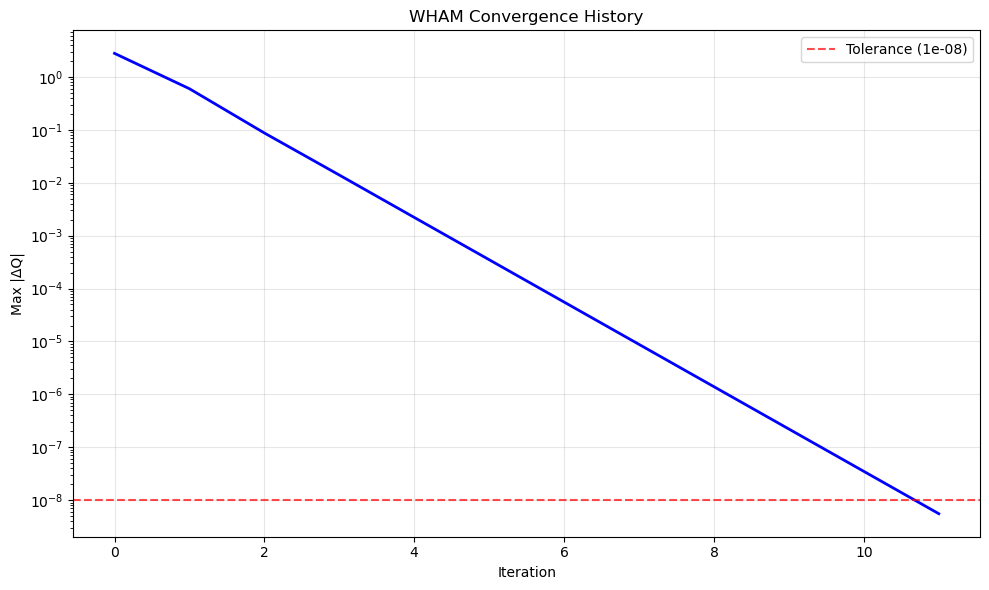

Convergence Summary:
  - Converged: True
  - Iterations: 12
  - Final change: 5.53e-09

WHAM Implementation Summary:
• Applied WHAM self-consistency equations to weight matrices
• Found optimal Q-factors for combining ensemble data
• Generated unbiased weight matrix from multiple ensembles
• Analyzed ensemble contributions and convergence

The WHAM matrix can now be used for transition probability calculations
and should provide better statistical accuracy than simple summation.


In [23]:
# Example usage of WHAM for weight matrices
if 'weight_matrices_results' in locals() and weight_matrices_results is not None:
    print("Applying WHAM to weight matrices...")
    print("\nThis implements WHAM where each transition [j,k] is treated as a histogram bin")
    print("that can be sampled by multiple ensembles with different statistical weights.")
    
    # Apply WHAM to the weight matrices
    wham_results = wham_weight_matrices(
        weight_matrix_3d=weight_matrices_results['weight_matrix_3d'],
        interfaces=weight_matrices_results['interfaces'],
        max_iterations=1000,
        tolerance=1e-8,
        verbose=True
    )
    
    print("\n" + "="*60)
    print("WHAM ANALYSIS COMPLETE")
    print("="*60)
    
    # Compare original vs WHAM results
    compare_wham_results(weight_matrices_results, wham_results)
    
    # Analyze ensemble contributions
    analyze_ensemble_contributions(wham_results)
    
    # Plot convergence (if matplotlib is available)
    try:
        plot_wham_convergence(wham_results)
    except NameError:
        print("\nNote: matplotlib not imported - skipping convergence plot")
    
    print("\n" + "="*60)
    print("WHAM Implementation Summary:")
    print("• Applied WHAM self-consistency equations to weight matrices")
    print("• Found optimal Q-factors for combining ensemble data") 
    print("• Generated unbiased weight matrix from multiple ensembles")
    print("• Analyzed ensemble contributions and convergence")
    print("\nThe WHAM matrix can now be used for transition probability calculations")
    print("and should provide better statistical accuracy than simple summation.")
    
else:
    print("Weight matrices not available. Please run the following steps first:")
    print("1. Load infretis data")
    print("2. Calculate infretis weights") 
    print("3. Compute weight matrices")
    print("\nThen re-run this cell to apply WHAM optimization.")

## WHAM for Weight Matrices: Detailed Explanation

### Theoretical Foundation

The implementation adapts the standard WHAM equations to work with transition weight matrices instead of order parameter histograms:

**Standard WHAM equations:**
```
ρ(λ) = Σᵢ ηᵢ Nᵢ(λ) / Σⱼ ηⱼ Qⱼ
Qᵢ = Σ_λ ρ(λ) [if ensemble i can sample λ]
```

**Matrix WHAM equations:**
```
W_WHAM[j,k] = Σᵢ ηᵢ Wᵢ[j,k] / Σⱼ ηⱼ Qⱼ [where ensemble j can sample transition j→k]
Qᵢ = Σ_{j,k} W_WHAM[j,k] [if ensemble i can sample transition j→k]
```

### Key Adaptations

1. **Histogram bins → Transition elements**: Each matrix element `[j,k]` represents a transition that can be sampled by multiple ensembles.

2. **Ensemble sampling rules**: The function `ensemble_can_sample_transition(i, j, k)` defines which ensembles can contribute to each transition, following TIS logic where ensemble `[i+]` primarily samples transitions starting from interface `i`.

3. **Q-factors**: Represent the relative statistical weight of each ensemble, automatically determined by WHAM to optimally combine overlapping data.

4. **Convergence**: The algorithm iterates until Q-factors stabilize, ensuring self-consistent combination of ensemble data.

### Advantages over Simple Summation

- **Optimal weighting**: Automatically determines how much to weight each ensemble based on statistical quality
- **Bias correction**: Accounts for different sampling efficiencies between ensembles  
- **Error reduction**: Properly combines overlapping information to reduce statistical noise
- **Self-consistency**: Ensures the final result is consistent with all ensemble data simultaneously

### Usage Notes

The WHAM-optimized matrix can be used in place of the simple summed matrix for:
- Transition probability calculations
- iSTAR model construction  
- Global crossing probability estimation

The Q-factors provide insight into the relative importance of each ensemble in the final result.